In [591]:
import pandas as pd
import pickle
import json
import seaborn as sns
import pprint
import numpy as np
import math
import ast
pp = pprint.PrettyPrinter(depth=6)
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
import scipy
from scipy.stats import normaltest, shapiro
matplotlib.rcParams['figure.figsize'] = (14.0, 5.0)
pd.set_option('display.max_columns', 120)
pd.set_option('display.max_rows', 450)
pd.set_option("display.max_colwidth", 200)

In [592]:
pkl_folder = "../../pkl"
csv_folder = "../../csv"
figure_folder = "../../figures"

For reference: https://nbviewer.jupyter.org/github/IncioMan/socialdata/blob/master/FinalProject/TrafficDataProject.ipynb

### Import

**Tags**

In [593]:
tags = pd.read_csv(f"{csv_folder}/tags_updated.csv", index_col=0)
tags.head()

,actual_release_date,Tag,Sha,Date,month,year,major_version,jira_version
0,NaN,4.5.6,12d931e5a31e1692a428bbb34ba11cd63aebf998,2015-10-16 09:31:18,10,2015,4,4.5.6
1,NaN,4.5.7,e2afb0bff1b8be759789d2c1bc9348de6f519f83,2016-04-08 13:44:39,4,2016,4,4.5.7
2,2015-04-23 00:00:00,5.1,4aa9af3a6a4362b61db365fba32eb0a55d411e7a,2015-04-02 08:09:45,4,2015,5,5.1
3,NaN,5.1.1,0a231d24c0f1e7ce1d200274b8e9bbe00f9f49fb,2015-06-02 08:34:06,6,2015,5,5.1.1
4,NaN,5.1.2,2a52a7106b2bfbd659c591c2d6fc09ad0ab2db5c,2015-07-27 08:03:21,7,2015,5,5.1.2


In [594]:
methods= ["dataset1", "dataset2"]

In [595]:
direct_and_pr = pd.read_csv(f"{csv_folder}/final_datasets/{methods[0]}_with_sw_metrics.csv", index_col=0)

In [596]:
iterative_pr_head_ref_cherry_picked = pd.read_csv(f"{csv_folder}/final_datasets/{methods[1]}_with_sw_metrics.csv", index_col=0)

In [597]:
methods_df = {"dataset1":direct_and_pr,
             "dataset2": iterative_pr_head_ref_cherry_picked}

### Features

| Variable name                            | Variable description                                                                                               | Variable type | How many      |
|------------------------------------------|--------------------------------------------------------------------------------------------------------------------|---------------|---------------|
| ratio_{state}_build                      | Ratio number of builds in the state over all builds for the release                                                | Continuous    | 4             |
| ratio_pr_build                           | Ratio number of pull request builds in the state over all builds for the release                                   | Continuous    | 1             |
| {aggr}_{state}_build_duration            | Aggregation for the duration of the builds in that state for the release                                           | Continuous    | 4 \* 3 = 12   |
| {aggr}\_n\_builds_per_pull_request       | Aggregation of the number of builds per pull request for the release                                               | Continuous    | 4             |
| {aggr}_failed_tests                      | Aggregation of the number failed tests per build for the release                                                   | Continuous    | 4             |
| {aggr}_errors_over_tests_total           | Aggregation of the number of error words over the tests run per build for the release                              | Continuous    | 4             |
| {aggr}_failures_over_tests_total         | Aggregation of the number of failures words over the tests run per build for the release                           | Continuous    | 4             |
| {aggr}_skipped_over_tests_total          | Aggregation of the number of skipped words over the tests run per build for the release                            | Continuous    | 4             |
| {aggr}\_n\_exceptions                    | Aggregation of the number of thrown exceptions per build for the release                                           | Continuous    | 4             |
| {aggr}\_n\_warnings                      | Aggregation of the number of warning words per build for the release                                               | Continuous    | 4             |
| {aggr}\_n\_error_classes                 | Aggregation of the number of error classes thrown per build for the release                                        | Continuous    | 4             |
| {state}\_gp{x}\_bs{y}\_n\_bursts_{aggr}  | Aggregation over number of bursts per commitref (branch/pull req) for a release, with gapsize x and burstsize y    | Continuous    | 3 \*9 \*4=108 |
| {state}\_gp{x}\_bs{y}\_burst_size_{aggr} | Aggregation over the sizes of bursts per commitref (branch/pull req) for a release, with gapsize x and burstsize y | Continuous    | 3 \*9 \*4=108 |
|                                          |                                                                                                                    |               | Total = 265   |

Remove unwanted features

In [598]:
for method in methods:
    methods_df[method] = methods_df[method].drop(columns=["ratio_pr_builds_failed"])

**Size**

In [599]:
for method in methods:
    print(methods_df[method].shape)

(52, 300)
(52, 300)


**Number burst metrics**

In [600]:
for method in methods:
    print(len([x for x in methods_df[method].columns if "burst" in x]))

216
216


**Number non burst metrics**

In [601]:
for method in methods:
    print(len([x for x in methods_df[method].columns if not "burst" in x]))

84
84


**Masks fo java build tool**

In [602]:
for method, df in methods_df.items():
    gradle_mask = df.java_build_tool == "gradle"
    print("Gradle", gradle_mask.sum())
    maven_mask = df.java_build_tool == "maven"
    print("Maven", maven_mask.sum())

Gradle 20
Maven 32
Gradle 20
Maven 32


In [603]:
all_mask = [True]*len(methods_df[methods[0]])

In [604]:
mask_name = "maven"
mask_to_use = maven_mask

**Extracting the dependent variables** 

In [605]:
dep_var_cols = ["java_build_tool","post_release_bugs", "fix_time", "dde", "critical_post_release_bugs", "minor_post_release_bugs"]

In [606]:
methods_dep_var = {}
for method in methods:
    methods_dep_var[method] = methods_df[method]\
    [dep_var_cols]
    methods_dep_var[method] = methods_dep_var[method][mask_to_use]

**Extracting the independent variables**

In [607]:
extra_info_cols = ['version_name','from_author_date', 'to_author_date', 'ahead_by', 'behind_by',
       'from_sha', 'to_sha', 'ahead_behind_sum', 'diff_author_dates',
       'diff_author_days', 'from_commit_date','to_commit_date', 'diff_commit_dates', 'diff_commit_days', 'to_tag',
       'from_tag', "java_build_tool"]

In [608]:
pre_release_bugs_columns = ["pre_release_bugs"]

In [609]:
methods_indep_var = {}
for method in methods:
    methods_indep_var[method] = methods_df[method].drop(columns=extra_info_cols + pre_release_bugs_columns + dep_var_cols)
    methods_indep_var[method] = methods_indep_var[method][mask_to_use]
    print(method, methods_indep_var[method].shape)

dataset1 (32, 277)
dataset2 (32, 277)


### Missing values

In [610]:
methods_indep_var[methods[0]].columns[\
                                    methods_indep_var[methods[1]].isna().sum()>0]

Index([], dtype='object')

In [611]:
methods_indep_var[methods[1]].columns[\
                                    methods_indep_var[methods[1]].isna().sum()>0]

Index([], dtype='object')

In [612]:
df = methods_indep_var[methods[0]]
df[df.min_failed_build_duration.isna()]

,ratio_passed_builds,ratio_canceled_builds,ratio_failed_builds,ratio_errored_builds,ratio_pr_builds,mean_not_errored_or_canceled_build_duration,median_not_errored_or_canceled_build_duration,max_not_errored_or_canceled_build_duration,min_not_errored_or_canceled_build_duration,mean_failed_build_duration,median_failed_build_duration,max_failed_build_duration,min_failed_build_duration,mean_passed_build_duration,median_passed_build_duration,max_passed_build_duration,min_passed_build_duration,mean_n_builds_per_pull_request,median_n_builds_per_pull_request,max_n_builds_per_pull_request,min_n_builds_per_pull_request,mean_errors_over_tests_total,median_errors_over_tests_total,max_errors_over_tests_total,min_errors_over_tests_total,mean_failed_tests,median_failed_tests,max_failed_tests,min_failed_tests,mean_failures_over_tests_total,median_failures_over_tests_total,max_failures_over_tests_total,min_failures_over_tests_total,mean_skipped_over_tests_total,median_skipped_over_tests_total,max_skipped_over_tests_total,min_skipped_over_tests_total,mean_n_exceptions,median_n_exceptions,max_n_exceptions,min_n_exceptions,mean_n_warnings,median_n_warnings,max_n_warnings,min_n_warnings,mean_n_error_classes,median_n_error_classes,max_n_error_classes,min_n_error_classes,not_passed_gp1_bs1_n_bursts_mean,not_passed_gp1_bs1_n_bursts_median,not_passed_gp1_bs1_n_bursts_max,not_passed_gp1_bs1_n_bursts_min,not_passed_gp1_bs1_burst_size_mean,not_passed_gp1_bs1_burst_size_median,not_passed_gp1_bs1_burst_size_max,not_passed_gp1_bs1_burst_size_min,not_passed_gp1_bs2_n_bursts_mean,not_passed_gp1_bs2_n_bursts_median,not_passed_gp1_bs2_n_bursts_max,...,failed_gp2_bs1_n_bursts_mean,failed_gp2_bs1_n_bursts_median,failed_gp2_bs1_n_bursts_max,failed_gp2_bs1_n_bursts_min,failed_gp2_bs1_burst_size_mean,failed_gp2_bs1_burst_size_median,failed_gp2_bs1_burst_size_max,failed_gp2_bs1_burst_size_min,failed_gp2_bs2_n_bursts_mean,failed_gp2_bs2_n_bursts_median,failed_gp2_bs2_n_bursts_max,failed_gp2_bs2_n_bursts_min,failed_gp2_bs2_burst_size_mean,failed_gp2_bs2_burst_size_median,failed_gp2_bs2_burst_size_max,failed_gp2_bs2_burst_size_min,failed_gp2_bs3_n_bursts_mean,failed_gp2_bs3_n_bursts_median,failed_gp2_bs3_n_bursts_max,failed_gp2_bs3_n_bursts_min,failed_gp2_bs3_burst_size_mean,failed_gp2_bs3_burst_size_median,failed_gp2_bs3_burst_size_max,failed_gp2_bs3_burst_size_min,failed_gp3_bs1_n_bursts_mean,failed_gp3_bs1_n_bursts_median,failed_gp3_bs1_n_bursts_max,failed_gp3_bs1_n_bursts_min,failed_gp3_bs1_burst_size_mean,failed_gp3_bs1_burst_size_median,failed_gp3_bs1_burst_size_max,failed_gp3_bs1_burst_size_min,failed_gp3_bs2_n_bursts_mean,failed_gp3_bs2_n_bursts_median,failed_gp3_bs2_n_bursts_max,failed_gp3_bs2_n_bursts_min,failed_gp3_bs2_burst_size_mean,failed_gp3_bs2_burst_size_median,failed_gp3_bs2_burst_size_max,failed_gp3_bs2_burst_size_min,failed_gp3_bs3_n_bursts_mean,failed_gp3_bs3_n_bursts_median,failed_gp3_bs3_n_bursts_max,failed_gp3_bs3_n_bursts_min,failed_gp3_bs3_burst_size_mean,failed_gp3_bs3_burst_size_median,failed_gp3_bs3_burst_size_max,failed_gp3_bs3_burst_size_min,mean_skipped_tests,median_skipped_tests,max_skipped_tests,min_skipped_tests,mean_total_tests,median_total_tests,max_total_tests,min_total_tests,mean_passed_tests,median_passed_tests,max_passed_tests,min_passed_tests


If we look at the ratio of builds in the state, we see that both datasets have missing values for duration due to no builds in that state being associated with that release.
We replace the values with 0.

In [613]:
for method in methods:
    methods_indep_var[method].fillna(0, inplace=True)

In [614]:
len(methods_indep_var[methods[1]].columns[\
                                    methods_indep_var[methods[1]].isna().sum()>0])\
+ len(methods_indep_var[methods[1]].columns[\
                                    methods_indep_var[methods[0]].isna().sum()>0])

0

### Drop columns with no information

In [615]:
method_uninformative_columns = {}
for method in methods:
    df = methods_indep_var[method]
    nunique = df.apply(pd.Series.nunique)
    cols_to_drop = nunique[nunique == 1].index
    method_uninformative_columns[method] = cols_to_drop
    methods_indep_var[method] = df.drop(cols_to_drop, axis=1)
    print(method, methods_indep_var[method].shape)

dataset1 (32, 199)
dataset2 (32, 197)


In [616]:
method_uninformative_columns[methods[0]].nunique()

78

In [617]:
set(method_uninformative_columns[methods[0]]).difference(set(method_uninformative_columns[methods[1]]))

set()

In [618]:
set(method_uninformative_columns[methods[1]]).difference(set(method_uninformative_columns[methods[0]]))

{'min_passed_tests', 'min_total_tests'}

In [619]:
method_uninformative_columns[methods[1]]

Index(['median_failed_tests', 'min_failed_tests',
       'min_skipped_over_tests_total', 'min_n_exceptions',
       'min_n_error_classes', 'not_passed_gp1_bs1_n_bursts_min',
       'not_passed_gp1_bs1_burst_size_min',
       'not_passed_gp1_bs2_n_bursts_median', 'not_passed_gp1_bs2_n_bursts_min',
       'not_passed_gp1_bs2_burst_size_min',
       'not_passed_gp1_bs3_n_bursts_median', 'not_passed_gp1_bs3_n_bursts_min',
       'not_passed_gp1_bs3_burst_size_min', 'not_passed_gp2_bs1_n_bursts_min',
       'not_passed_gp2_bs1_burst_size_min',
       'not_passed_gp2_bs2_n_bursts_median', 'not_passed_gp2_bs2_n_bursts_min',
       'not_passed_gp2_bs2_burst_size_min',
       'not_passed_gp2_bs3_n_bursts_median', 'not_passed_gp2_bs3_n_bursts_min',
       'not_passed_gp2_bs3_burst_size_min', 'not_passed_gp3_bs1_n_bursts_min',
       'not_passed_gp3_bs1_burst_size_min',
       'not_passed_gp3_bs2_n_bursts_median', 'not_passed_gp3_bs2_n_bursts_min',
       'not_passed_gp3_bs2_burst_size_min',
    

### Statistical summary

**Method 0**

Not burst metrics

In [620]:
methods_indep_var[methods[1]][[x for x in methods_indep_var[methods[1]].columns if not "burst" in x]].describe()

,ratio_passed_builds,ratio_canceled_builds,ratio_failed_builds,ratio_errored_builds,ratio_pr_builds,mean_not_errored_or_canceled_build_duration,median_not_errored_or_canceled_build_duration,max_not_errored_or_canceled_build_duration,min_not_errored_or_canceled_build_duration,mean_failed_build_duration,median_failed_build_duration,max_failed_build_duration,min_failed_build_duration,mean_passed_build_duration,median_passed_build_duration,max_passed_build_duration,min_passed_build_duration,mean_n_builds_per_pull_request,median_n_builds_per_pull_request,max_n_builds_per_pull_request,min_n_builds_per_pull_request,mean_errors_over_tests_total,median_errors_over_tests_total,max_errors_over_tests_total,min_errors_over_tests_total,mean_failed_tests,max_failed_tests,mean_failures_over_tests_total,median_failures_over_tests_total,max_failures_over_tests_total,min_failures_over_tests_total,mean_skipped_over_tests_total,median_skipped_over_tests_total,max_skipped_over_tests_total,mean_n_exceptions,median_n_exceptions,max_n_exceptions,mean_n_warnings,median_n_warnings,max_n_warnings,min_n_warnings,mean_n_error_classes,median_n_error_classes,max_n_error_classes,mean_skipped_tests,median_skipped_tests,max_skipped_tests,mean_total_tests,median_total_tests,max_total_tests,mean_passed_tests,median_passed_tests,max_passed_tests
count,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.00000,32.000000,32.00000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000
mean,0.688773,0.132697,0.131478,0.047053,0.291817,2894.651940,2854.406250,8972.156250,758.281250,2344.948568,2341.906250,4663.906250,925.562500,2995.357453,2941.562500,8817.000000,1461.500000,3.547252,2.656250,20.062500,1.281250,3.367016,0.706048,1120.520145,0.000500,0.182980,160.156250,2.374105,0.209199,883.761112,0.011073,4.407314,0.997506,226.459355,22.759926,2.312500,620.781250,122.215045,25.000000,1493.531250,0.21875,1.072265,0.09375,107.593750,1.590415,0.546875,12.468750,2985.605587,553.781250,15890.875000,2983.832192,551.203125,15888.812500
std,0.129225,0.122421,0.062372,0.042578,0.096640,2190.943534,2161.318898,9327.032883,1300.281191,2092.135152,2282.306136,3422.226962,1614.601278,2226.859577,2194.294753,9345.435995,1681.664268,1.649914,1.340664,22.071639,1.300977,6.054131,0.745675,3400.865136,0.001416,0.280485,345.304738,5.793140,0.235621,3270.869008,0.032475,4.755406,1.471436,338.150797,11.690527,6.472959,994.619776,54.917461,21.111837,1279.214048,0.79248,0.960163,0.53033,272.086782,1.568130,0.796761,15.564609,1678.177917,967.072627,6391.248673,1678.524408,967.317690,6391.083261
min,0.411899,0.000000,0.022222,0.000000,0.000000,678.538462,457.000000,1377.000000,0.000000,405.250000,296.000000,561.000000,0.000000,728.227273,457.000000,1377.000000,60.000000,0.000000,0.000000,0.000000,0.000000,0.083054,0.000000,0.188000,0.000000,0.000000,0.000000,0.071978,0.000000,0.161137,0.000000,0.040042,0.000000,0.148309,7.238095,0.000000,35.000000,29.000000,1.000000,58.000000,0.00000,0.000000,0.00000,0.000000,0.401366,0.000000,1.000000,1089.301587,0.000000,8873.000000,1088.714286,0.000000,8872.000000
25%,0.625622,0.041637,0.095360,0.021361,0.224045,994.855586,1089.500000,2434.750000,77.250000,727.880461,681.250000,1340.750000,79.250000,1040.343877,1190.750000,2434.750000,131.500000,2.656250,2.000000,4.000000,1.000000,0.927995,0.171243,6.250000,0.000000,0.000000,0.000000,0.599167,0.000830,6.750000,0.000000,0.113028,0.000948,24.750000,10.794989,0.000000,115.000000,68.090984,4.750000,759.000000,0.00000,0.263395,0.00000,7.750000,0.634762,0.000000,4.000000,1314.242772,46.000000,10158.500000,1308.949247,41.0000

In [621]:
methods_indep_var[methods[0]][[x for x in methods_indep_var[methods[1]].columns if not "burst" in x]].describe()

,ratio_passed_builds,ratio_canceled_builds,ratio_failed_builds,ratio_errored_builds,ratio_pr_builds,mean_not_errored_or_canceled_build_duration,median_not_errored_or_canceled_build_duration,max_not_errored_or_canceled_build_duration,min_not_errored_or_canceled_build_duration,mean_failed_build_duration,median_failed_build_duration,max_failed_build_duration,min_failed_build_duration,mean_passed_build_duration,median_passed_build_duration,max_passed_build_duration,min_passed_build_duration,mean_n_builds_per_pull_request,median_n_builds_per_pull_request,max_n_builds_per_pull_request,min_n_builds_per_pull_request,mean_errors_over_tests_total,median_errors_over_tests_total,max_errors_over_tests_total,min_errors_over_tests_total,mean_failed_tests,max_failed_tests,mean_failures_over_tests_total,median_failures_over_tests_total,max_failures_over_tests_total,min_failures_over_tests_total,mean_skipped_over_tests_total,median_skipped_over_tests_total,max_skipped_over_tests_total,mean_n_exceptions,median_n_exceptions,max_n_exceptions,mean_n_warnings,median_n_warnings,max_n_warnings,min_n_warnings,mean_n_error_classes,median_n_error_classes,max_n_error_classes,mean_skipped_tests,median_skipped_tests,max_skipped_tests,mean_total_tests,median_total_tests,max_total_tests,mean_passed_tests,median_passed_tests,max_passed_tests
count,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.00000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.00000,32.000000,32.000000,32.000000,32.000000,32.000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000
mean,0.740417,0.079910,0.126027,0.053646,0.467062,2972.835968,2858.171875,5958.750000,890.937500,2344.418726,2385.953125,3992.81250,994.281250,3067.557573,2923.718750,5876.312500,1883.406250,3.572681,2.625000,20.062500,1.281250,3.190042,0.624093,1041.800209,0.000683,0.140532,99.531250,2.325558,0.230332,859.576655,0.011073,3.934426,0.948961,146.051440,30.788679,2.843750,334.281250,176.608998,24.781250,1298.093750,0.21875,1.495389,0.187500,49.125000,1.774661,0.875,7.906250,4135.927399,818.468750,15190.093750,4134.012205,815.640625,15183.906250
std,0.080458,0.050600,0.051435,0.055570,0.199627,2142.876313,2087.011143,4221.270112,1370.492728,2158.975502,2351.361498,3146.66752,1586.491793,2156.458965,2092.521164,4160.527932,1723.788324,1.674371,1.529284,22.071639,1.300977,6.804618,0.724810,3415.471627,0.001527,0.256642,303.210774,6.553811,0.216075,3276.582015,0.032475,4.631738,1.472985,264.319365,19.860626,8.160129,638.772676,96.663694,24.232056,1050.035187,0.79248,1.269019,0.737804,167.164155,1.638113,1.000,8.811134,2497.989920,1300.502954,6009.494935,2497.825272,1298.606072,6008.852015
min,0.571429,0.000000,0.026316,0.000000,0.000000,927.800000,957.000000,1377.000000,0.000000,391.250000,311.000000,506.00000,0.000000,1038.375000,990.000000,1377.000000,93.000000,0.000000,0.000000,0.000000,0.000000,0.087503,0.000000,0.188000,0.000000,0.000000,0.000000,0.069257,0.000947,0.161137,0.000000,0.062701,0.000000,0.148309,6.489796,0.000000,35.000000,29.000000,1.000000,58.000000,0.00000,0.000000,0.000000,0.000000,0.436787,0.000,1.000000,999.183673,29.000000,8873.000000,998.673469,29.000000,8872.000000
25%,0.693874,0.041793,0.088219,0.009573,0.296244,1255.558440,1286.625000,2318.250000,179.000000,722.559072,663.250000,1277.00000,198.250000,1345.797525,1329.750000,2318.250000,770.000000,2.612981,2.000000,4.000000,1.000000,0.216058,0.130302,4.750000,0.000000,0.000000,0.000000,0.345287,0.068903,5.000000,0.000000,0.093794,0.000949,18.333333,9.868537,0.000000,72.750000,77.453208,6.000000,759.000000,0.00000,0.140816,0.000000,6.750000,0.643675,0.000,4.000000,1383.199822,53.000000,10154.750000,1380.924766,52.250000,10153.750000

Our features are all continuous:
* Because of their nature we know they should not present negative values and indeed they do not
* Ratio features should range between 0 and 1: they correctly do
* Min_all_build_duration presents negative values: this is due to erros in the build dataset (fixed)

Burst metrics

In [622]:
methods_indep_var[methods[0]].shape

(32, 199)

In [623]:
methods_indep_var[methods[0]][[x for x in methods_indep_var[methods[0]].columns if "burst" in x]].describe()

,not_passed_gp1_bs1_n_bursts_mean,not_passed_gp1_bs1_n_bursts_median,not_passed_gp1_bs1_n_bursts_max,not_passed_gp1_bs1_burst_size_mean,not_passed_gp1_bs1_burst_size_median,not_passed_gp1_bs1_burst_size_max,not_passed_gp1_bs2_n_bursts_mean,not_passed_gp1_bs2_n_bursts_max,not_passed_gp1_bs2_burst_size_mean,not_passed_gp1_bs2_burst_size_median,not_passed_gp1_bs2_burst_size_max,not_passed_gp1_bs3_n_bursts_mean,not_passed_gp1_bs3_n_bursts_max,not_passed_gp1_bs3_burst_size_mean,not_passed_gp1_bs3_burst_size_median,not_passed_gp1_bs3_burst_size_max,not_passed_gp2_bs1_n_bursts_mean,not_passed_gp2_bs1_n_bursts_median,not_passed_gp2_bs1_n_bursts_max,not_passed_gp2_bs1_burst_size_mean,not_passed_gp2_bs1_burst_size_median,not_passed_gp2_bs1_burst_size_max,not_passed_gp2_bs2_n_bursts_mean,not_passed_gp2_bs2_n_bursts_max,not_passed_gp2_bs2_burst_size_mean,not_passed_gp2_bs2_burst_size_median,not_passed_gp2_bs2_burst_size_max,not_passed_gp2_bs3_n_bursts_mean,not_passed_gp2_bs3_n_bursts_max,not_passed_gp2_bs3_burst_size_mean,not_passed_gp2_bs3_burst_size_median,not_passed_gp2_bs3_burst_size_max,not_passed_gp3_bs1_n_bursts_mean,not_passed_gp3_bs1_n_bursts_median,not_passed_gp3_bs1_n_bursts_max,not_passed_gp3_bs1_burst_size_mean,not_passed_gp3_bs1_burst_size_median,not_passed_gp3_bs1_burst_size_max,not_passed_gp3_bs2_n_bursts_mean,not_passed_gp3_bs2_n_bursts_max,not_passed_gp3_bs2_burst_size_mean,not_passed_gp3_bs2_burst_size_median,not_passed_gp3_bs2_burst_size_max,not_passed_gp3_bs3_n_bursts_mean,not_passed_gp3_bs3_n_bursts_max,not_passed_gp3_bs3_burst_size_mean,not_passed_gp3_bs3_burst_size_median,not_passed_gp3_bs3_burst_size_max,canceled_gp1_bs1_n_bursts_mean,canceled_gp1_bs1_n_bursts_median,canceled_gp1_bs1_n_bursts_max,canceled_gp1_bs1_burst_size_mean,canceled_gp1_bs1_burst_size_median,canceled_gp1_bs1_burst_size_max,canceled_gp1_bs2_n_bursts_mean,canceled_gp1_bs2_n_bursts_max,canceled_gp1_bs2_burst_size_mean,canceled_gp1_bs2_burst_size_median,canceled_gp1_bs2_burst_size_max,canceled_gp1_bs3_n_bursts_mean,...,canceled_gp3_bs1_burst_size_median,canceled_gp3_bs1_burst_size_max,canceled_gp3_bs2_n_bursts_mean,canceled_gp3_bs2_n_bursts_max,canceled_gp3_bs2_burst_size_mean,canceled_gp3_bs2_burst_size_median,canceled_gp3_bs2_burst_size_max,canceled_gp3_bs3_n_bursts_mean,canceled_gp3_bs3_n_bursts_max,canceled_gp3_bs3_burst_size_mean,canceled_gp3_bs3_burst_size_median,canceled_gp3_bs3_burst_size_max,failed_gp1_bs1_n_bursts_mean,failed_gp1_bs1_n_bursts_median,failed_gp1_bs1_n_bursts_max,failed_gp1_bs1_burst_size_mean,failed_gp1_bs1_burst_size_median,failed_gp1_bs1_burst_size_max,failed_gp1_bs2_n_bursts_mean,failed_gp1_bs2_n_bursts_max,failed_gp1_bs2_burst_size_mean,failed_gp1_bs2_burst_size_median,failed_gp1_bs2_burst_size_max,failed_gp1_bs3_n_bursts_mean,failed_gp1_bs3_n_bursts_max,failed_gp1_bs3_burst_size_mean,failed_gp1_bs3_burst_size_median,failed_gp1_bs3_burst_size_max,failed_gp2_bs1_n_bursts_mean,failed_gp2_bs1_n_bursts_median,failed_gp2_bs1_n_bursts_max,failed_gp2_bs1_burst_size_mean,failed_gp2_bs1_burst_size_median,failed_gp2_bs1_burst_size_max,failed_gp2_bs2_n_bursts_mean,failed_gp2_bs2_n_bursts_max,failed_gp2_bs2_burst_size_mean,failed_gp2_bs2_burst_size_median,failed_gp2_bs2_burst_size_max,failed_gp2_bs3_n_bursts_mean,failed_gp2_bs3_n_bursts_max,failed_gp2_bs3_burst_size_mean,failed_gp2_bs3_burst_size_median,failed_gp2_bs3_burst_size_max,failed_gp3_bs1_n_bursts_mean,failed_gp3_bs1_n_bursts_median,failed_gp3_bs1_n_bursts_max,failed_gp3_bs1_burst_size_mean,failed_gp3_bs1_burst_size_median,failed_gp3_bs1_burst_size_max,failed_gp3_bs2_n_bursts_mean,failed_gp3_bs2_n_bursts_max,failed_gp3_bs2_burst_size_mean,failed_gp3_bs2_burst_size_median,failed_gp3_bs2_burst_size_max,failed_gp3_bs3_n_bursts_mean,failed_gp3_bs3_n_bursts_max,failed_gp3_bs3_burst_size_mean,failed_gp3_bs3_burst_size_median,failed_gp3_bs3_burst_size_max
count,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.00000

Burst metrics should all be positive and they indeed are

### Perfectly correlated features

In [624]:
methods_fully_correlated_features = {}
for method in methods:
    corr_matrix = methods_indep_var[method].corr().abs()
    sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                      .stack()
                      .sort_values(ascending=False)).round(decimals = 3)
    methods_fully_correlated_features[method] = sol[sol > 0.999]

In [625]:
methods_corr_cols_to_remove = {}
for method in methods:
    cols_to_remove = set()
    for pair in methods_fully_correlated_features[method].index:
        if((pair[1] in cols_to_remove) or (pair[0] in cols_to_remove)):
            continue
        else:
            cols_to_remove.add(pair[0])
    methods_corr_cols_to_remove[method] = cols_to_remove
    print(method, len(cols_to_remove))

dataset1 103
dataset2 108


**How many columns to remove due to perfect correlation are burst metric?**

In [626]:
for method in methods:
    print(method, len([col for col in methods_corr_cols_to_remove[method] if "burst" in col])\
          /len(methods_corr_cols_to_remove[method]))

dataset1 0.9611650485436893
dataset2 0.9722222222222222


There are a couple not burst features

In [627]:
[col for col in methods_corr_cols_to_remove[methods[0]] if  not "burst" in col]

['max_total_tests',
 'median_total_tests',
 'min_total_tests',
 'mean_total_tests']

In [628]:
[col for col in methods_corr_cols_to_remove[methods[1]] if  not "burst" in col]

['max_total_tests', 'median_total_tests', 'mean_total_tests']

In [629]:
for col in [col for col in methods_corr_cols_to_remove[methods[1]] if  not "burst" in col]:
    x = methods_fully_correlated_features[methods[1]]
    print(col,":\n", x[col])

max_total_tests :
 max_passed_tests    1.0
dtype: float64
median_total_tests :
 median_passed_tests    1.0
dtype: float64
mean_total_tests :
 mean_passed_tests    1.0
dtype: float64


Remove the perfectly correlated columns

In [630]:
for method in methods:
    cols_to_remove = methods_corr_cols_to_remove[method]
    methods_indep_var[method] = methods_indep_var[method].drop(columns=cols_to_remove, errors="ignore")
    print(methods_indep_var[method].shape)

(32, 96)
(32, 89)


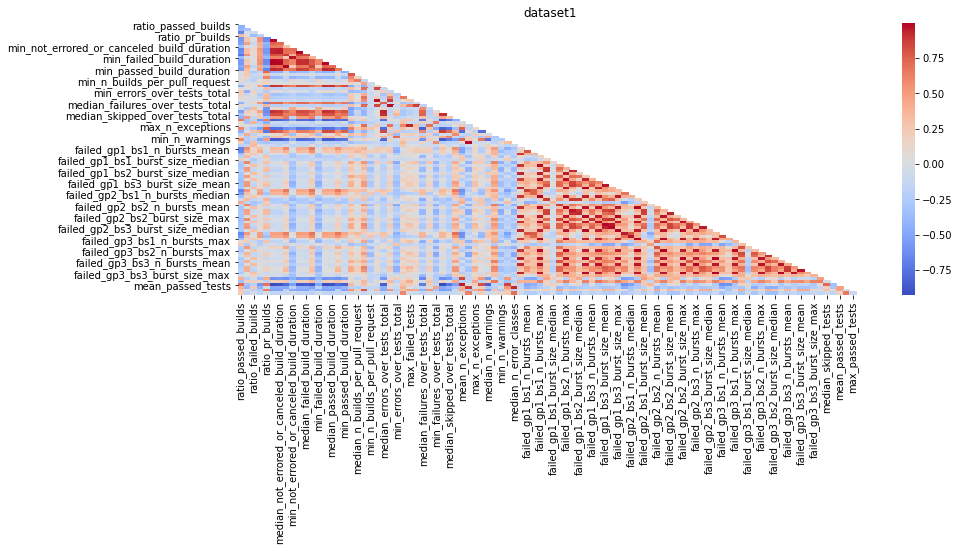

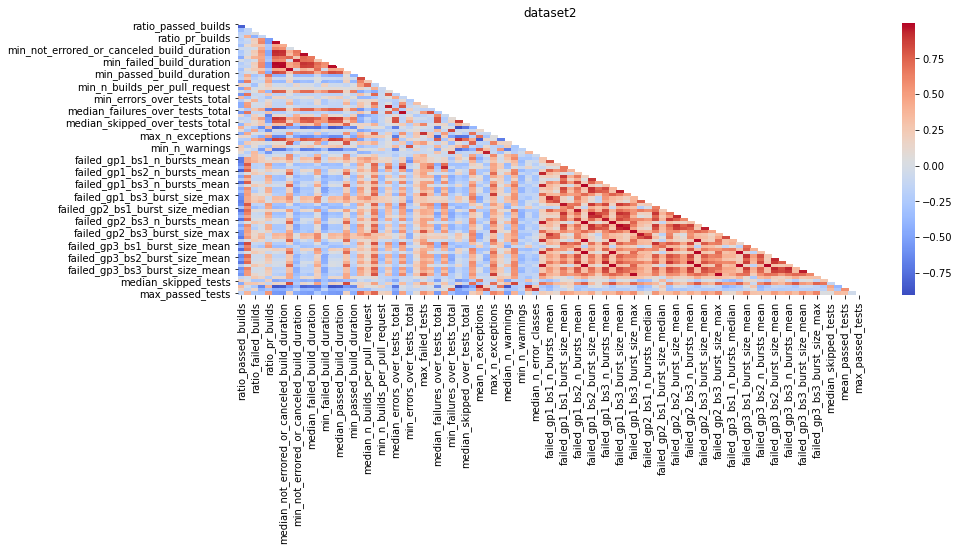

In [631]:
for method in methods:
    matrix = np.triu(methods_indep_var[method].corr())
    ax = sns.heatmap(methods_indep_var[method].corr(), cmap= 'coolwarm', mask=matrix)
    ax.set_title(method)
    plt.show()

**Do datasets have same columns?**

In [632]:
set(methods_indep_var[methods[0]]).difference(set(methods_indep_var[methods[1]]))

{'failed_gp1_bs1_n_bursts_max',
 'failed_gp1_bs2_burst_size_max',
 'failed_gp2_bs1_n_bursts_max',
 'failed_gp2_bs2_burst_size_max',
 'failed_gp2_bs2_n_bursts_max',
 'failed_gp3_bs2_burst_size_max',
 'min_passed_tests'}

In [633]:
set(methods_indep_var[methods[1]]).difference(set(methods_indep_var[methods[0]]))

set()

### Normal distribution

In [634]:
method_normal_distributed_features = {}
for method in methods:
    shapiro_feat = methods_indep_var[method].apply(lambda x: shapiro(x)).T
    shapiro_feat.columns = ["statistic", "pval"]
    normal_feat = methods_indep_var[method].apply(lambda x: normaltest(x)).T
    normal_feat.columns = ["statistic", "pval"]
    method_normal_distributed_features[method] = list(shapiro_feat[shapiro_feat.pval > 0.05].index)\
    + list(normal_feat[normal_feat.pval > 0.05].index)

<AxesSubplot:ylabel='Frequency'>

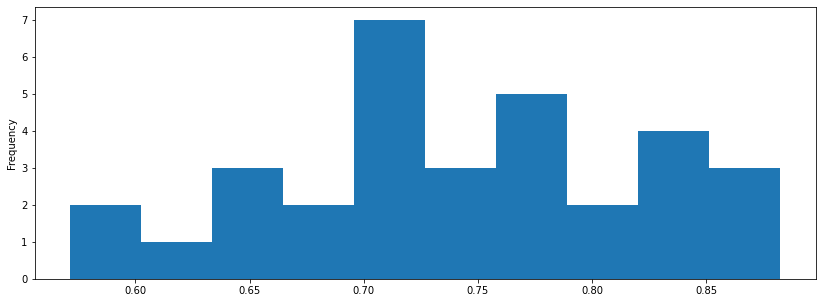

In [635]:
methods_indep_var[methods[0]].ratio_passed_builds.plot(kind="hist")

<Figure size 1008x360 with 0 Axes>

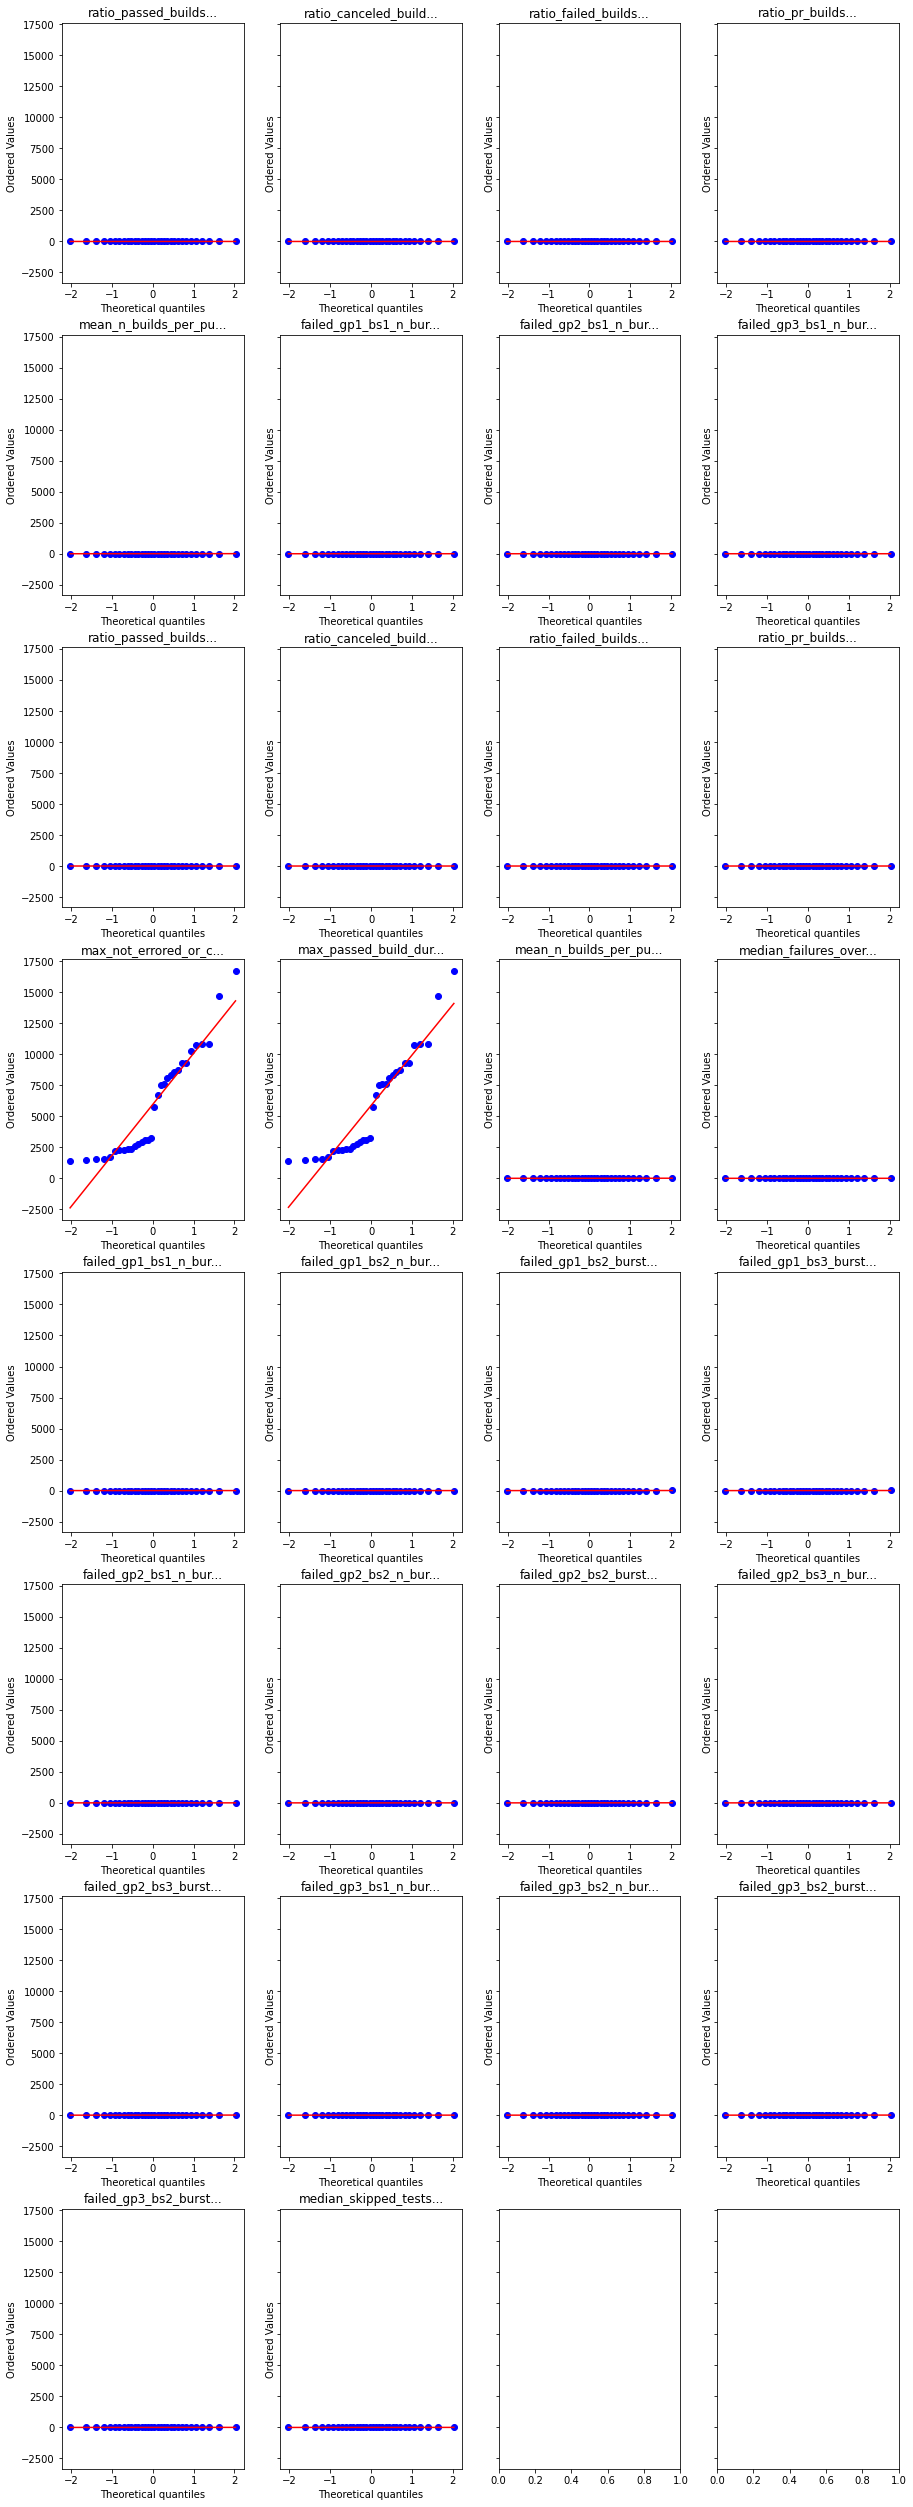

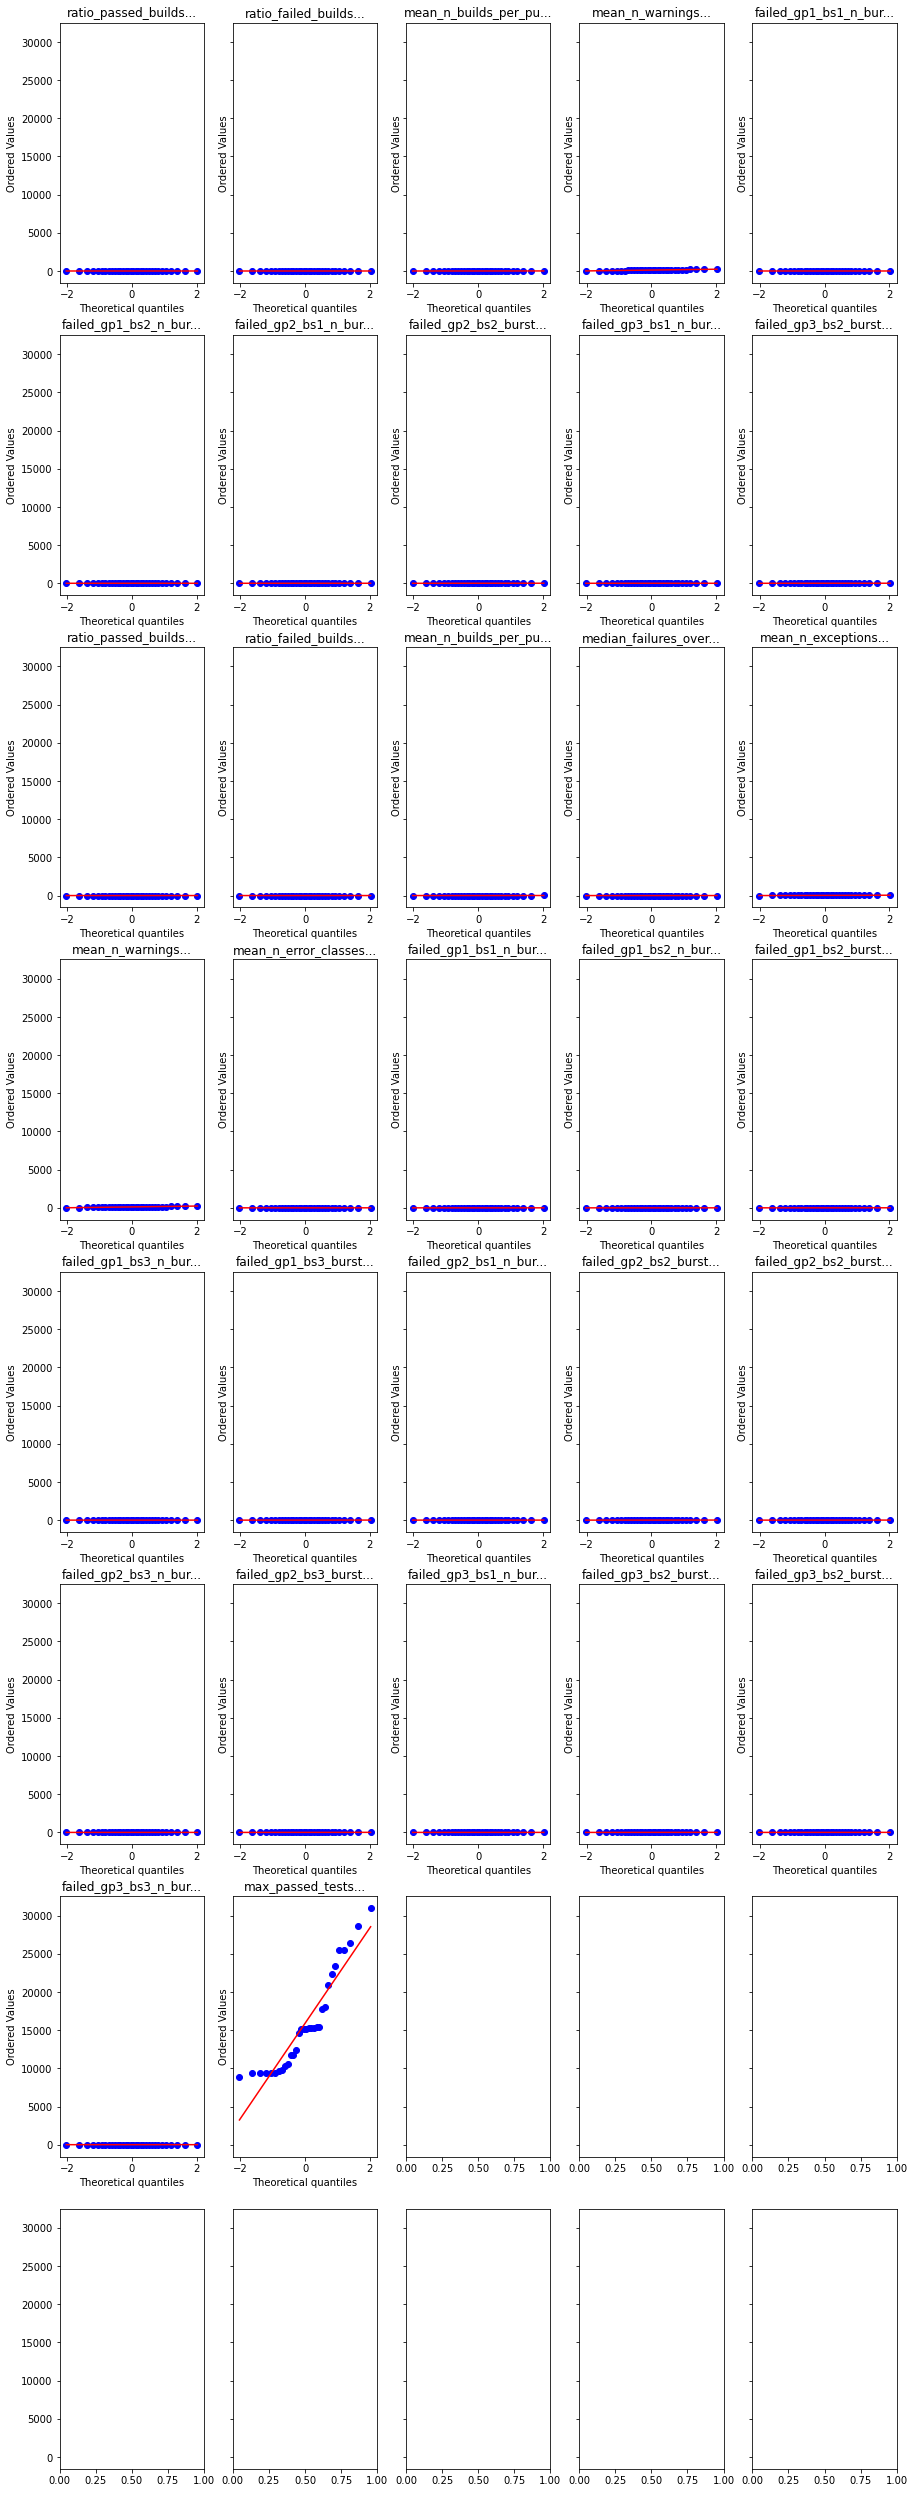

In [636]:
plt.figure()
normal_features = {}
for method in methods:
    df = methods_indep_var[method]
    normal_features[method] = method_normal_distributed_features[method]
    if(len(normal_features) < 1):
        continue
    fig, axes = plt.subplots(nrows=8, ncols=int(len(normal_features[method])/8)+1, sharey=True, figsize=(15.0, 45.0))
    axes = axes.flatten()
    for i, feat in enumerate(normal_features[method]):
        scipy.stats.probplot(df[feat], dist="norm", plot=axes[i])
        axes[i].set_title(feat[:20]+"...")
#plt.savefig(f"{figure_folder}/dataset_preprocessing/{mask_name}_qq-plot.png", transparent=True, bbox_inches='tight', pad_inches=0.2)
#plt.show()

In [637]:
for method in methods:
    x = normal_features[method]
    print(method, len(x))

dataset1 30
dataset2 32


In [638]:
for method in methods:
    print(normaltest(methods_dep_var[method].post_release_bugs))

NormaltestResult(statistic=16.783332445777187, pvalue=0.00022674914880033611)
NormaltestResult(statistic=16.783332445777187, pvalue=0.00022674914880033611)


A visual test does seem to confirm that these features are indeed normally distributed.

### Correlated features

<Figure size 1008x360 with 0 Axes>

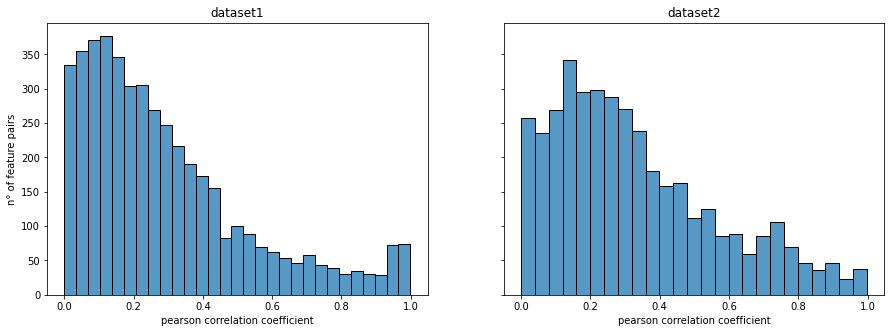

In [639]:
plt.figure()
methods_correlated_features = {}
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15.0, 5.0))
for i, method in enumerate(methods):
    corr_matrix = methods_indep_var[method].corr().abs()
    sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                      .stack()
                      .sort_values(ascending=False)).round(decimals = 3)
    methods_correlated_features[method] = sol[sol > 0.8]
    ax = sns.histplot(sol, ax=axes[i])
    ax.set_title(method)
    ax.set(xlabel="pearson correlation coefficient",ylabel="n° of feature pairs")
plt.savefig(f"{figure_folder}/dataset_preprocessing/{mask_name}_correlated_feature_dist.png", transparent=True, bbox_inches='tight', pad_inches=0.2)
plt.show()

In [640]:
methods_correlated_features[methods[1]].head(10)

failed_gp2_bs3_n_bursts_max                  failed_gp3_bs3_n_bursts_max    0.998
failed_gp1_bs2_n_bursts_max                  failed_gp3_bs2_n_bursts_max    0.998
max_not_errored_or_canceled_build_duration   max_passed_build_duration      0.998
failed_gp3_bs1_n_bursts_max                  failed_gp3_bs2_n_bursts_max    0.997
mean_not_errored_or_canceled_build_duration  mean_passed_build_duration     0.997
failed_gp1_bs3_n_bursts_max                  failed_gp2_bs3_n_bursts_max    0.997
failed_gp1_bs2_n_bursts_max                  failed_gp2_bs3_n_bursts_max    0.996
                                             failed_gp3_bs1_n_bursts_max    0.996
failed_gp1_bs3_n_bursts_max                  failed_gp3_bs3_n_bursts_max    0.995
failed_gp1_bs2_n_bursts_max                  failed_gp3_bs3_n_bursts_max    0.995
dtype: float64

In [641]:
methods_correlated_features[methods[0]].head(10)

failed_gp1_bs2_burst_size_max                failed_gp1_bs3_burst_size_max    0.999
failed_gp2_bs2_burst_size_max                failed_gp2_bs3_burst_size_max    0.999
failed_gp3_bs2_burst_size_max                failed_gp3_bs3_burst_size_max    0.999
failed_gp2_bs1_n_bursts_max                  failed_gp3_bs1_n_bursts_max      0.999
failed_gp1_bs1_n_bursts_max                  failed_gp2_bs1_n_bursts_max      0.998
mean_not_errored_or_canceled_build_duration  mean_passed_build_duration       0.997
failed_gp2_bs2_n_bursts_max                  failed_gp3_bs2_n_bursts_max      0.996
failed_gp2_bs2_burst_size_max                failed_gp3_bs2_burst_size_max    0.996
failed_gp2_bs3_burst_size_max                failed_gp3_bs3_burst_size_max    0.995
failed_gp2_bs2_burst_size_max                failed_gp3_bs3_burst_size_max    0.995
dtype: float64

### Correlation with dependent variable
https://dataschool.com/fundamentals-of-analysis/correlation-and-p-value/

We proceed with analysing the correlation of our attributed with the three software quality metricsm
We calculate both types of correlation:
* Pearons (linear)
* Spearman (monotonic, is pearson applied to ranks)

https://support.minitab.com/en-us/minitab-express/1/help-and-how-to/modeling-statistics/regression/supporting-topics/basics/a-comparison-of-the-pearson-and-spearman-correlation-methods/#:~:text=The%20Pearson%20correlation%20evaluates%20the%20linear%20relationship%20between%20two%20continuous%20variables.&text=The%20Spearman%20correlation%20coefficient%20is,evaluate%20relationships%20involving%20ordinal%20variables.

In [642]:
methods_pearson_corr_post_release_bugs = {}
methods_spearman_corr_post_release_bugs = {}
for method in methods:
    data = []
    corr_col = methods_dep_var[method].post_release_bugs
    x = methods_indep_var[method][normal_features[method]].apply(lambda x:\
                                scipy.stats.pearsonr(x, corr_col)).T
    x.columns = ["pearson_corr", "pval"]
    methods_pearson_corr_post_release_bugs[method] = x

    x = methods_indep_var[method].drop(normal_features[method], axis=1).apply(lambda x:\
                                scipy.stats.spearmanr(x, corr_col)).T
    x.columns = ["spearman_corr", "pval"]
    methods_spearman_corr_post_release_bugs[method] = x

**Feature category correlation per each dataset**

In [643]:
feature_categories = ["ratio_(.*)_builds",
                     "(.*)_(.*)_build_duration",
                     "(.*)_n_builds_per_pull_request",
                     "(.*)_errors_over_tests_total",
                     "(.*)_failed_tests",
                     "(.*)_failures_over_tests_total",
                     "(.*)_skipped_over_tests_total",
                     "(.*)_n_exceptions",
                     "(.*)_n_warnings",
                     "(.*)_n_error_classes",
                     #"(.*)_burst_size",
                     "(.*)burst"]

In [644]:
linearly_corr_features = {}
for method in methods:
    x = methods_pearson_corr_post_release_bugs[method]
    linearly_corr_features[method] = x[x.pval < 0.05].index
    x["abs"] = x.pearson_corr.abs()
    print(x[x.pval < 0.05].sort_values(by="abs",ascending=False)[["pearson_corr"]].round(2).to_latex())

\begin{tabular}{lr}
\toprule
{} &  pearson\_corr \\
\midrule
failed\_gp3\_bs2\_burst\_size\_mean   &          0.58 \\
failed\_gp1\_bs3\_burst\_size\_median &          0.50 \\
failed\_gp2\_bs3\_burst\_size\_median &          0.47 \\
failed\_gp2\_bs3\_n\_bursts\_mean     &          0.47 \\
failed\_gp2\_bs2\_n\_bursts\_mean     &          0.44 \\
failed\_gp1\_bs2\_n\_bursts\_mean     &          0.42 \\
failed\_gp2\_bs2\_burst\_size\_mean   &          0.41 \\
failed\_gp3\_bs2\_burst\_size\_median &          0.40 \\
failed\_gp1\_bs2\_burst\_size\_mean   &          0.39 \\
failed\_gp3\_bs2\_n\_bursts\_mean     &          0.38 \\
failed\_gp2\_bs1\_n\_bursts\_mean     &          0.36 \\
failed\_gp2\_bs1\_n\_bursts\_mean     &          0.36 \\
\bottomrule
\end{tabular}

\begin{tabular}{lr}
\toprule
{} &  pearson\_corr \\
\midrule
failed\_gp3\_bs3\_n\_bursts\_mean     &          0.62 \\
failed\_gp2\_bs3\_n\_bursts\_mean     &          0.59 \\
failed\_gp3\_bs2\_burst\_size\_mean   &          0.57

In [645]:
for method in methods:
    x = methods_spearman_corr_post_release_bugs[method]
    x["abs"] = x.spearman_corr.abs()
    print(x[x.pval < 0.05].sort_values(by="abs",ascending=False)[["spearman_corr"]].round(2).to_latex())

\begin{tabular}{lr}
\toprule
{} &  spearman\_corr \\
\midrule
failed\_gp2\_bs3\_n\_bursts\_max      &           0.78 \\
failed\_gp1\_bs2\_n\_bursts\_max      &           0.78 \\
failed\_gp3\_bs1\_n\_bursts\_max      &           0.77 \\
failed\_gp2\_bs2\_n\_bursts\_max      &           0.77 \\
failed\_gp3\_bs3\_burst\_size\_mean   &           0.77 \\
max\_failed\_tests                 &           0.76 \\
failed\_gp1\_bs3\_n\_bursts\_max      &           0.75 \\
failed\_gp2\_bs3\_burst\_size\_max    &           0.75 \\
failed\_gp3\_bs2\_n\_bursts\_max      &           0.75 \\
failed\_gp3\_bs3\_burst\_size\_max    &           0.74 \\
failed\_gp2\_bs2\_burst\_size\_max    &           0.74 \\
failed\_gp3\_bs3\_n\_bursts\_max      &           0.74 \\
failed\_gp2\_bs1\_n\_bursts\_max      &           0.74 \\
failed\_gp3\_bs2\_burst\_size\_max    &           0.73 \\
failed\_gp3\_bs3\_burst\_size\_median &           0.73 \\
failed\_gp1\_bs1\_n\_bursts\_max      &           0.72 \\
failed\_gp1\_

import re
for cat in feature_categories:
    print("-"*10)
    print(cat)
    for method in methods:
        x = methods_spearman_corr_post_release_bugs[method]
        x = x[x.pval < 0.05].round(2)
        print(method, "\n", x[[True if re.search(cat, s) else False for s in x.index]]\
              .spearman_corr.sort_values(ascending=False).to_latex())

In [646]:
corr = methods_spearman_corr_post_release_bugs[methods[1]]
corr = corr[corr.pval < 0.05]
spearman_corr = corr.spearman_corr
spearman_corr = spearman_corr.reindex(spearman_corr.abs().sort_values(ascending=False).index)
spearman_corr

failed_gp1_bs2_n_bursts_max                   0.775061
failed_gp2_bs3_n_bursts_max                   0.759532
failed_gp3_bs1_n_bursts_max                   0.758243
failed_gp3_bs2_n_bursts_max                   0.741342
failed_gp1_bs3_n_bursts_max                   0.738380
max_n_error_classes                           0.723533
failed_gp3_bs3_burst_size_mean                0.720991
failed_gp2_bs2_n_bursts_mean                  0.720576
failed_gp2_bs3_burst_size_max                 0.717508
max_failed_tests                              0.711763
failed_gp1_bs3_burst_size_max                 0.702806
failed_gp3_bs3_n_bursts_max                   0.702147
failed_gp3_bs3_burst_size_max                 0.698509
max_n_builds_per_pull_request                 0.697041
failed_gp3_bs3_burst_size_median              0.672887
failed_gp3_bs1_burst_size_mean                0.659205
max_n_exceptions                              0.652042
failed_gp2_bs3_burst_size_mean                0.643826
failed_gp1

In [647]:
spearman_corr[[col for col in spearman_corr.index if re.search("(.*)_(.*)_build_duration", col)]]

max_failed_build_duration                     0.459276
max_passed_build_duration                     0.441377
max_not_errored_or_canceled_build_duration    0.434365
min_failed_build_duration                    -0.392422
Name: spearman_corr, dtype: float64

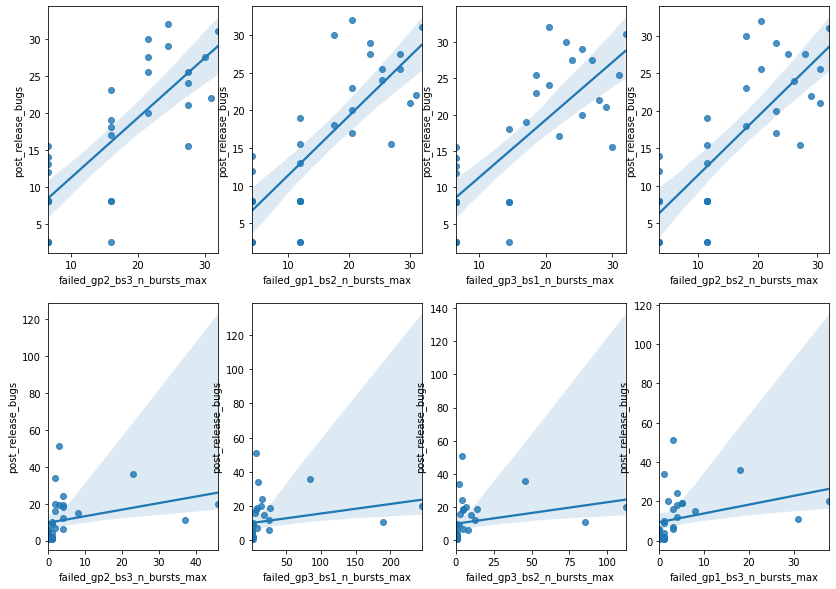

In [648]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(14.0, 10.0))
axes = axes.flatten()

corr = methods_spearman_corr_post_release_bugs[methods[0]]
corr = corr[corr.pval < 0.05]
spearman_corr = corr.spearman_corr
spearman_corr = spearman_corr.reindex(spearman_corr.abs().sort_values(ascending=False).index)
for i in range(4):
    feature = spearman_corr.index[i]
    sns.regplot(x=methods_indep_var[methods[0]][feature].rank(),
                   y=methods_dep_var[methods[0]].post_release_bugs.rank(), ax=axes[i])
    
corr = methods_spearman_corr_post_release_bugs[methods[1]]
corr = corr[corr.pval < 0.05]
spearman_corr = corr.spearman_corr
spearman_corr = spearman_corr.reindex(spearman_corr.abs().sort_values(ascending=False).index)
for j in range(i+1, 8):
    feature = spearman_corr.index[j-i]
    sns.regplot(x=methods_indep_var[methods[1]][feature],
                   y=methods_dep_var[methods[1]].post_release_bugs, ax=axes[j])

df = methods_spearman_corr_post_release_bugs[methods[0]].sort_values()
df = df.reindex(df.abs().sort_values(ascending=False).index)
ax = df[[col for col in df.index if not "burst" in col]].head(20).plot(kind="bar")
ax.set_title("Top 20 spearman rank correlations with post release bugs (no burst metrics)")

(-0.19123347658414325, 0.2944288612720535)


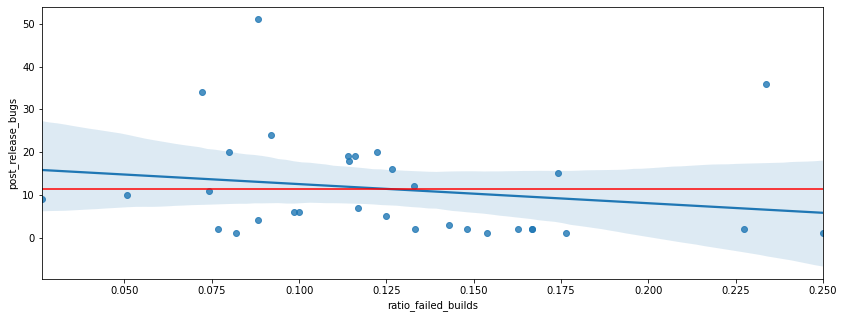

In [649]:
df_ind = methods_indep_var[methods[0]]
df_dep = methods_dep_var[methods[0]]
x = df_ind.ratio_failed_builds
y = df_dep.post_release_bugs
print(scipy.stats.pearsonr(x,y))
ax = sns.regplot(x=x, y=y)
ax.axhline(y=df_dep.post_release_bugs.mean(), color="r")

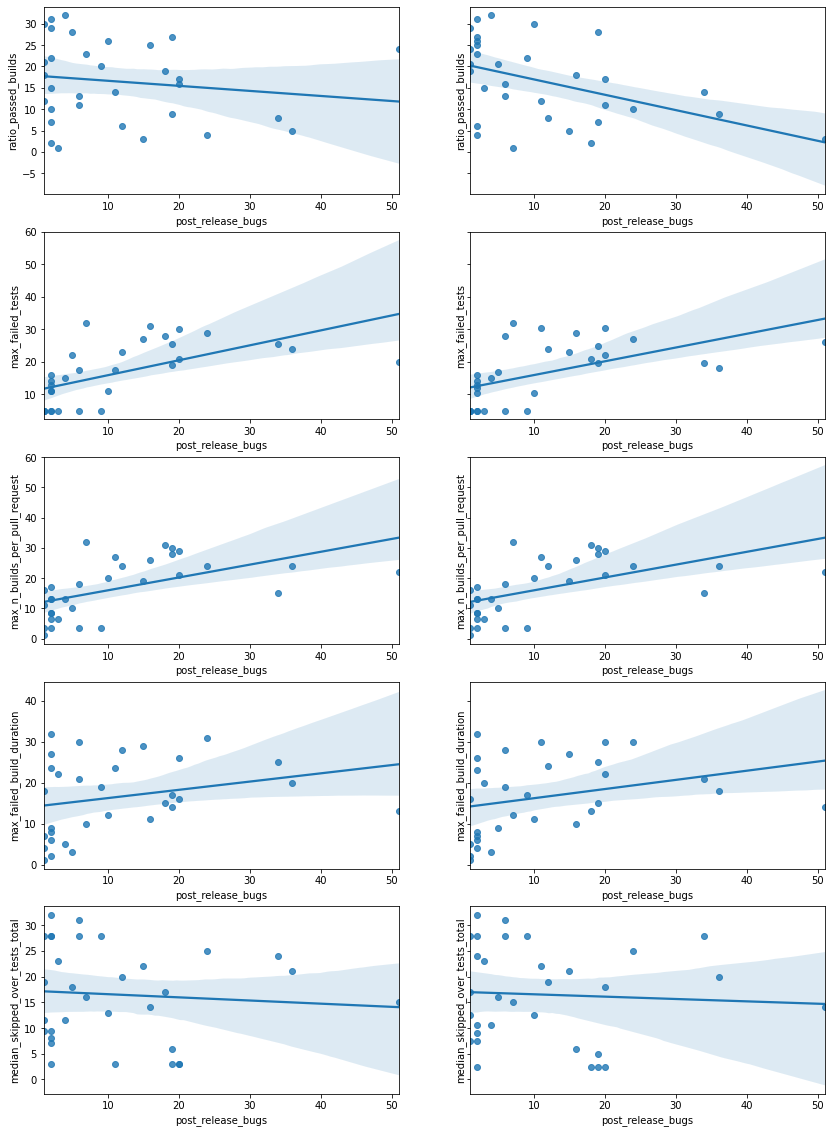

In [650]:
columns = ["ratio_passed_builds", "max_failed_tests",\
          "max_n_builds_per_pull_request", "max_failed_build_duration", "median_skipped_over_tests_total"]
fig, axes = plt.subplots(nrows=len(columns), ncols=2, sharey='row', figsize=(14.0, 4*len(columns)))
axes = axes.flatten()
i = 0
for col in columns:
    df_ind = methods_indep_var[methods[0]]
    df_dep = methods_dep_var[methods[0]]
    sns.regplot(y=df_ind[col].rank(), x=df_dep.post_release_bugs, ax=axes[i])
    i+=1
    df_ind = methods_indep_var[methods[1]]
    df_dep = methods_dep_var[methods[1]]
    sns.regplot(y=df_ind[col].rank(), x=df_dep.post_release_bugs, ax=axes[i])
    i+=1

In [651]:
corr = methods_spearman_corr_post_release_bugs[methods[1]]
corr = corr[corr.pval < 0.05]
spearman_corr = corr.spearman_corr
spearman_corr = spearman_corr.reindex(spearman_corr.abs().sort_values(ascending=False).index)
spearman_corr[spearman_corr.abs() > 0.35].index

Index(['failed_gp1_bs2_n_bursts_max', 'failed_gp2_bs3_n_bursts_max',
       'failed_gp3_bs1_n_bursts_max', 'failed_gp3_bs2_n_bursts_max',
       'failed_gp1_bs3_n_bursts_max', 'max_n_error_classes',
       'failed_gp3_bs3_burst_size_mean', 'failed_gp2_bs2_n_bursts_mean',
       'failed_gp2_bs3_burst_size_max', 'max_failed_tests',
       'failed_gp1_bs3_burst_size_max', 'failed_gp3_bs3_n_bursts_max',
       'failed_gp3_bs3_burst_size_max', 'max_n_builds_per_pull_request',
       'failed_gp3_bs3_burst_size_median', 'failed_gp3_bs1_burst_size_mean',
       'max_n_exceptions', 'failed_gp2_bs3_burst_size_mean',
       'failed_gp1_bs3_burst_size_mean', 'mean_failed_tests',
       'failed_gp3_bs2_n_bursts_mean', 'max_failures_over_tests_total',
       'failed_gp1_bs1_burst_size_mean', 'max_n_warnings',
       'failed_gp3_bs1_n_bursts_median', 'max_skipped_over_tests_total',
       'max_skipped_tests', 'ratio_canceled_builds',
       'failed_gp2_bs1_burst_size_mean', 'median_n_builds_per_pull_

cols = ['max_failed_tests', 'max_n_builds_per_pull_request',
       'mean_failed_tests', 'failed_gp3_bs1_n_bursts_max',
       'failed_gp3_bs3_burst_size_max', 'max_failed_build_duration',
       'max_n_error_classes', 'median_skipped_over_tests_total',
       'failed_gp1_bs1_burst_size_mean', 'max_n_exceptions',
       'ratio_passed_builds','mean_n_builds_per_pull_request',
        'min_skipped_over_tests_total', 'max_failures_over_tests_total']
df = methods_indep_var[methods[1]][cols].corr(method="spearman")
cols = []
matrix = np.triu(df) 
ax = sns.heatmap(df, cmap= 'coolwarm', mask=matrix, annot=True) 
#ax.set_title(method) 
plt.show()

<AxesSubplot:>

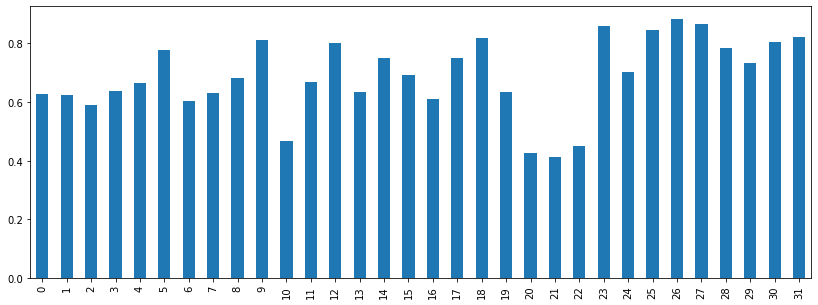

In [652]:
methods_indep_var[methods[1]].ratio_passed_builds.plot(kind="bar")

<AxesSubplot:>

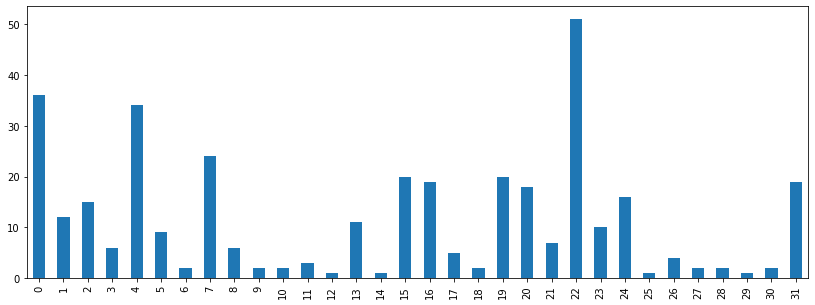

In [653]:
methods_dep_var[methods[1]].post_release_bugs.plot(kind="bar")

<AxesSubplot:>

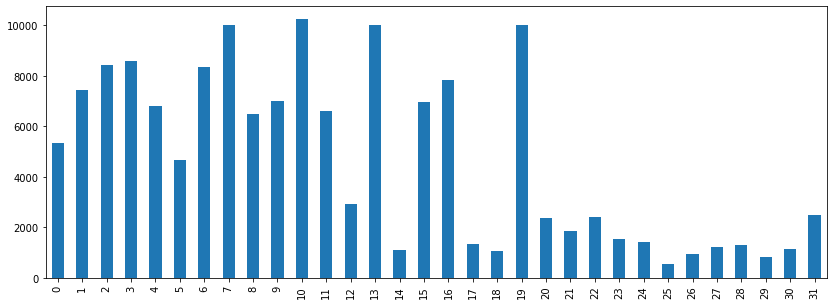

In [654]:
methods_indep_var[methods[1]].max_failed_build_duration.plot(kind="bar")

In [655]:
methods_indep_var[methods[1]].max_failed_build_duration.corr(\
                        methods_indep_var[methods[1]].min_not_errored_or_canceled_build_duration, method="spearman")

0.07685958025540664

**Remove highly correlated features?**

In [656]:
methods_corr_cols_to_remove = {}
for method in methods:
    cols_to_remove = set()
    print(method, len(methods_correlated_features[method]))
    corr_matrix = methods_indep_var[method].corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    methods_corr_cols_to_remove[method] = [column for column in upper.columns if any(upper[column] > 0.9)]

dataset1 265
dataset2 186


In [657]:
for method in methods:
    cols_to_remove = methods_corr_cols_to_remove[method]
    methods_indep_var[method] = methods_indep_var[method].drop(columns=cols_to_remove, errors="ignore")
    print(methods_indep_var[method].shape)

(32, 54)
(32, 46)


for method in methods:
    matrix = np.triu(methods_indep_var[method].corr())
    ax = sns.heatmap(methods_indep_var[method].corr(), cmap= 'coolwarm', mask=matrix)
    ax.set_title(method)
    plt.show()

### Play with feature selection

In [658]:
# example of correlation feature selection for numerical data
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression, RFECV
from sklearn.model_selection import KFold, LeaveOneOut, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.dummy import DummyRegressor
from sklearn.isotonic import IsotonicRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import f1_score, precision_score, make_scorer
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA

In [659]:
regression_mask = mask_to_use
cross_validation_strategy = KFold(4, shuffle=True, random_state=1)

In [660]:
method_x_train = {}
method_y_train = {}
method_train_columns = {}
for method in methods:
    X_train = methods_indep_var[method][regression_mask]
    y_train = methods_dep_var[method].post_release_bugs[regression_mask]
    train_columns = X_train.columns
    X_train[X_train.columns] = StandardScaler().fit_transform(X_train)
    method_x_train[method] = X_train
    method_y_train[method] = y_train
    method_train_columns[method] = train_columns

<ipython-input-660-4f638e0bc459>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_train = methods_indep_var[method][regression_mask]
<ipython-input-660-4f638e0bc459>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_train = methods_indep_var[method][regression_mask]


In [661]:
def two_layer_cross_validate(model, params_grid, x, y, num_trials, n_splits, scoring=None):
    inner_cv = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    outer_cv = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    # Non_nested parameter search and scoring
    clf = GridSearchCV(estimator=model, param_grid=params_grid, cv=inner_cv)
    """clf.fit(method_x_train[methods[1]], method_y_train[methods[1]])
    non_nested_scores[i] = clf.best_score_
    """
    # Nested CV with parameter optimization
    return cross_val_score(clf, x, y, cv=outer_cv, scoring=scoring)

In [662]:
def outer_layer_cross_validate(model, x, y, seed, n_splits, scoring=None):
    outer_cv = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    return cross_val_score(model, x, y, cv=outer_cv, scoring=scoring)

In [663]:
def forward_feature_selection(model, X, y, cv=5, scoring="r2"):
    best_performance = np.array([-100])
    added_columns = list()
    feature_performance = {}
    feature_performance["All features"] = perf = cross_val_score(model, X,\
                                   y, cv=cv, scoring=scoring)
    while(True):
        #print("Best perf", best_performance)
        current_perf = best_performance
        curr_col = None
        for col in X.columns:
            if col in added_columns:
                continue
            perf = cross_val_score(model, X[set(added_columns).union(set([col]))],\
                                   y, cv=cv, scoring=scoring)
            #print(added_columns.union(set([col])), perf.mean())
            if current_perf.mean() < perf.mean():
                current_perf = perf
                curr_col = col
        if current_perf.mean() <= best_performance:
            break
        else:
            best_performance = current_perf.mean()
            added_columns.append(curr_col)
            feature_performance[curr_col] = current_perf
            #print(added_columns)
    return added_columns, best_performance, feature_performance

**Regression**

In [529]:
#n_estimators = [int(x) for x in np.linspace(start = 200, stop = 800, num = 4)]
min_samples_leaf = [1,2,3,4]
max_depth = [4,8,16,None]
params_grid = {'min_samples_leaf': min_samples_leaf,
               "max_depth" : max_depth
              }

model = DecisionTreeRegressor()
method_randomregressor_r2 = {}
method_randomregressor_neg_mean_error = {}
for method in methods:
    method_randomregressor_r2[method] = \
            two_layer_cross_validate(model, params_grid, method_x_train[method], method_y_train[method], 5, 4, "r2")
    method_randomregressor_neg_mean_error[method] = \
        two_layer_cross_validate(model, params_grid, method_x_train[method], method_y_train[method], 5, 4, "neg_mean_absolute_error")

In [530]:
for method in methods:
    print("R2","-"*40)
    print(method, method_randomregressor_r2[method])
    print("Nmae","-"*40)
    print(method, method_randomregressor_neg_mean_error[method])

R2 ----------------------------------------
dataset1 [ 0.26713979 -0.20841353  0.32131322  0.85559567]
Nmae ----------------------------------------
dataset1 [-8.2125     -7.15625    -5.81041667 -1.6875    ]
R2 ----------------------------------------
dataset2 [-1.44813392 -0.12551595  0.0879377   0.24612417]
Nmae ----------------------------------------
dataset2 [-7.375      -7.0875     -4.4        -4.04285714]


In [531]:
method_knn_regr_features = {}
method_knn_feature_performance = {}
for method in methods:
    features, score, feature_performance = forward_feature_selection(KNeighborsRegressor(), method_x_train[method],\
                                           method_y_train[method], cv=cross_validation_strategy)
    print("-"*20)
    print(method, features, score)
    print("-"*20)
    method_knn_regr_features[method] = features
    method_knn_feature_performance = feature_performance

--------------------
dataset1 ['failed_gp1_bs1_n_bursts_max', 'failed_gp1_bs1_burst_size_median', 'min_n_builds_per_pull_request', 'failed_gp3_bs1_burst_size_median'] 0.594482247105169
--------------------
--------------------
dataset2 ['max_failed_tests', 'max_skipped_tests', 'min_n_warnings'] 0.6192230107651209
--------------------


<Figure size 1008x360 with 0 Axes>

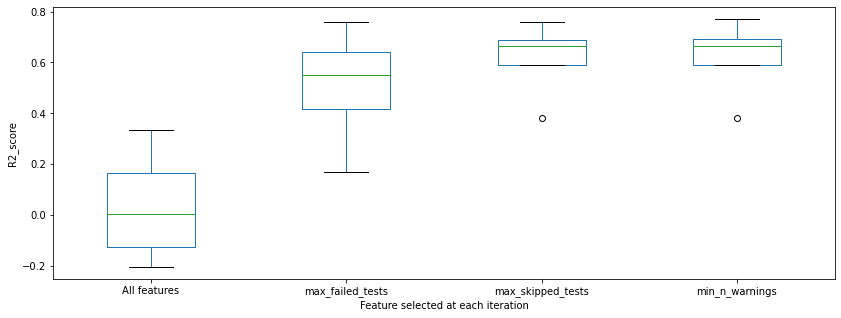

In [532]:
plt.figure()
ax = pd.DataFrame(method_knn_feature_performance).plot(kind="box")
ax.set(ylabel="R2_score", xlabel="Feature selected at each iteration")
plt.savefig(f"{figure_folder}/machine_learning_results/{mask_name}/knn_feature_selection_r2.png", transparent=True, bbox_inches='tight', pad_inches=0.2)
plt.show()

In [533]:
params_grid = {'n_neighbors': [int(x) for x in np.linspace(start = 1, stop = 10, num = 5)],
              'p': [1,2,3]}
model = KNeighborsRegressor()
method_knregressor_r2 = {}
method_knregressor_neg_mean_error = {}
for method in methods:
    x = method_x_train[method][method_knn_regr_features[method]]
    method_knregressor_r2[method] = \
        two_layer_cross_validate(model, params_grid, x, method_y_train[method], 5, 4, "r2")
    method_knregressor_neg_mean_error[method] = \
        two_layer_cross_validate(model, params_grid, x, method_y_train[method], 5, 4, "neg_mean_absolute_error")

In [534]:
for method in methods:
    print("R2","-"*40)
    print(method, method_knregressor_r2[method])
    print(method_knregressor_r2[method].mean())
    print("Nmae","-"*40)
    print(method, method_knregressor_neg_mean_error[method])

R2 ----------------------------------------
dataset1 [0.3924373  0.65331289 0.35970896 0.31407942]
0.42988464133601006
Nmae ----------------------------------------
dataset1 [-8.33333333 -5.125      -7.5        -4.125     ]
R2 ----------------------------------------
dataset2 [ 0.412346    0.21909143  0.44401444 -0.30899853]
0.1916133359697091
Nmae ----------------------------------------
dataset2 [-8.16666667 -6.875      -6.75       -6.04166667]


In [535]:
"""def forward_cross_validation(model, X, y):
    best_performance = cross_val_score(DummyRegressor(strategy="mean"), X, y, scoring="neg_mean_absolute_error").mean()
    added_columns = set()
    while(True):
        print("Best perf", best_performance)
        current_perf = best_performance
        curr_col = None
        for col in X.columns:
            if col in added_columns:
                continue
            perf = cross_val_score(model, X[added_columns.union(set([col]))], y, scoring="neg_mean_absolute_error")
            print(added_columns.union(set([col])), perf.mean())
            if current_perf < perf.mean():
                current_perf = perf.mean()
                curr_col = col
        print("end cycle", col, current_perf)
        if current_perf <= best_performance:
            break
        else:
            best_performance = current_perf
            added_columns.add(curr_col)
            print(added_columns)
    return added_columns, best_performance"""

'def forward_cross_validation(model, X, y):\n    best_performance = cross_val_score(DummyRegressor(strategy="mean"), X, y, scoring="neg_mean_absolute_error").mean()\n    added_columns = set()\n    while(True):\n        print("Best perf", best_performance)\n        current_perf = best_performance\n        curr_col = None\n        for col in X.columns:\n            if col in added_columns:\n                continue\n            perf = cross_val_score(model, X[added_columns.union(set([col]))], y, scoring="neg_mean_absolute_error")\n            print(added_columns.union(set([col])), perf.mean())\n            if current_perf < perf.mean():\n                current_perf = perf.mean()\n                curr_col = col\n        print("end cycle", col, current_perf)\n        if current_perf <= best_performance:\n            break\n        else:\n            best_performance = current_perf\n            added_columns.add(curr_col)\n            print(added_columns)\n    return added_columns, best_pe

In [536]:
method_lin_regr_features = {}
method_lin_regr_feature_performance = {}
for i, method in enumerate(methods):
    #columns = method_x_train[method].columns.intersection(linearly_corr_features[method])
    features, score, feature_performance = forward_feature_selection(LinearRegression(), method_x_train[method],\
                                           method_y_train[method], cv=cross_validation_strategy)
    print("-"*20)
    print(method, features, score)
    print("-"*20)
    method_lin_regr_features[method] = features
    if i == 0:
        method_lin_regr_feature_performance = feature_performance

--------------------
dataset1 ['failed_gp3_bs3_burst_size_mean', 'failed_gp3_bs3_n_bursts_mean', 'failed_gp1_bs1_burst_size_median', 'failed_gp3_bs1_burst_size_median', 'failed_gp3_bs2_burst_size_mean', 'failed_gp2_bs1_burst_size_median'] 0.5766430032853529
--------------------
--------------------
dataset2 ['failed_gp1_bs2_n_bursts_mean', 'max_n_error_classes', 'mean_n_builds_per_pull_request', 'min_n_builds_per_pull_request', 'mean_skipped_tests'] 0.3800990114975544
--------------------


<Figure size 1008x360 with 0 Axes>

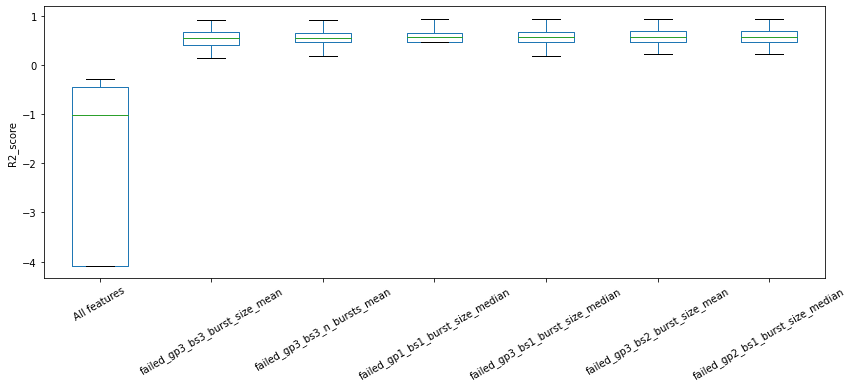

In [537]:
plt.figure()
ax = pd.DataFrame(method_lin_regr_feature_performance).plot(kind="box", showfliers=False)
ax.set(ylabel="R2_score")
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
plt.savefig(f"{figure_folder}/machine_learning_results/{mask_name}/linreg_feature_selection_r2.png", transparent=True, bbox_inches='tight', pad_inches=0.2)
plt.show()

In [538]:
method_linregression_r2 = {}
method_linregression_nmae = {}
for method in methods:
    features = method_lin_regr_features[method]
    method_linregression_r2[method] = outer_layer_cross_validate(LinearRegression(), method_x_train[method][features],\
                    method_y_train[method], 5, 4, scoring="r2")
    method_linregression_nmae[method] = outer_layer_cross_validate(LinearRegression(), method_x_train[method][features],\
                    method_y_train[method], 5, 4, scoring="neg_mean_absolute_error")

In [539]:
for method in methods:
    print("R2","-"*40)
    print(method, method_linregression_r2[method])
    print(method_linregression_r2[method].mean())
    print("Nmae","-"*40)
    print(method, method_linregression_nmae[method])

R2 ----------------------------------------
dataset1 [0.75881521 0.66931479 0.3231429  0.35548192]
0.5266887053413134
Nmae ----------------------------------------
dataset1 [-2.85988227 -4.2855388  -6.15764587 -7.85090788]
R2 ----------------------------------------
dataset2 [-0.91955172  0.33851085  0.1076735   0.22762379]
-0.06143589391418186
Nmae ----------------------------------------
dataset2 [-6.85667975 -5.06736499 -8.35475158 -8.1476439 ]


is_small = y_train < y_train.quantile(.25)
is_large = y_train > y_train.quantile(.75)
is_medium = ~(is_small | is_large)

y_quantiles = y_train.mask(is_small, 'small').mask(is_large, 'large').mask(is_medium, 'medium')

<Figure size 1008x360 with 0 Axes>

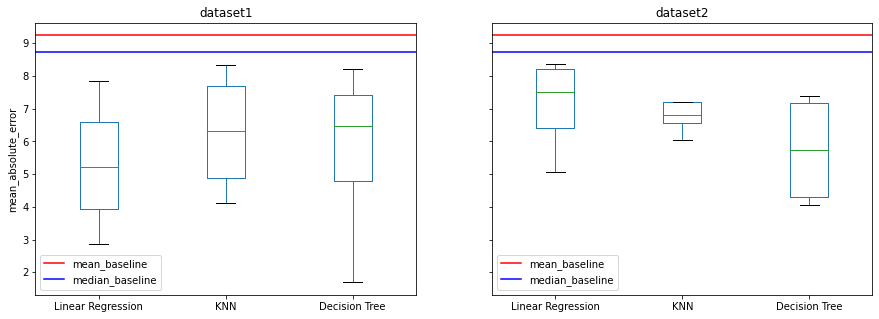

In [540]:
plt.figure()
fig, axes = plt.subplots(nrows=1, ncols=len(methods), sharey=True, figsize=(15.0, 5.0))
scores = {"Linear Regression":method_linregression_nmae,
          "KNN": method_knregressor_neg_mean_error,
          "Decision Tree": method_randomregressor_neg_mean_error
         }
for i, method in enumerate(methods):
    data = {}
    for model, score in scores.items():
        data[model] = -score[method]
    ax = pd.DataFrame(data).plot(kind="box", showfliers=False, ax=axes[i])
    x = method_x_train[method]
    y = method_y_train[method]
    ax.axhline(y=mean_absolute_error(DummyRegressor(strategy="mean").fit(x, y).predict(y), y),color='r', label="mean_baseline")
    ax.axhline(y=mean_absolute_error(DummyRegressor(strategy="median").fit(x, y).predict(y), y),color='b', label="median_baseline")
    ax.legend()
    ax.set_title(method)
    if i == 0:
        ax.set(ylabel="mean_absolute_error")
plt.savefig(f"{figure_folder}/machine_learning_results/{mask_name}/regression_neg_mean_absolute_error.png", transparent=True, bbox_inches='tight', pad_inches=0.2)

<Figure size 1008x360 with 0 Axes>

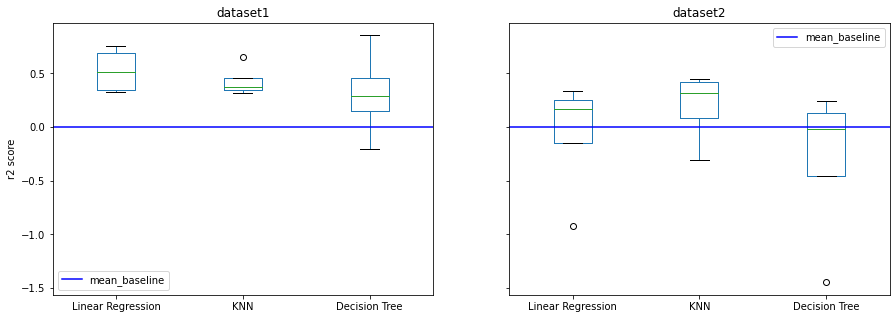

In [541]:
plt.figure()
fig, axes = plt.subplots(nrows=1, ncols=len(methods), sharey=True, figsize=(15.0, 5.0))
scores = {"Linear Regression":method_linregression_r2,
          "KNN": method_knregressor_r2, 
          "Decision Tree": method_randomregressor_r2
         }
for i, method in enumerate(methods):
    data = {}
    for model, score in scores.items():
        data[model] = score[method]
    ax = pd.DataFrame(data).plot(kind="box", ax=axes[i])
    x = method_x_train[method]
    y = method_y_train[method]
    #ax.axhline(y=r2_score(DummyRegressor(strategy="mean").fit(x, y).predict(y), y),color='r', label="mean_baseline")
    ax.axhline(y=r2_score(DummyRegressor(strategy="median").fit(x, y).predict(y), y),color='b', label="mean_baseline")
    ax.legend()
    ax.set_title(method)
    if i == 0:
        ax.set(ylabel="r2 score")
plt.savefig(f"{figure_folder}/machine_learning_results/{mask_name}/regression_r2.png", transparent=True, bbox_inches='tight', pad_inches=0.2)

**Linear Regression analysis**

In [542]:
x = methods_indep_var[methods[0]][method_lin_regr_features[methods[0]]]
y = methods_dep_var[methods[0]].post_release_bugs
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, shuffle=True, random_state=42)
model = LinearRegression().fit(x,y)

In [543]:
x.corr()

,failed_gp3_bs3_burst_size_mean,failed_gp3_bs3_n_bursts_mean,failed_gp1_bs1_burst_size_median,failed_gp3_bs1_burst_size_median,failed_gp3_bs2_burst_size_mean,failed_gp2_bs1_burst_size_median
failed_gp3_bs3_burst_size_mean,1.000000,0.886196,-0.203144,-0.331013,0.856396,-0.341027
failed_gp3_bs3_n_bursts_mean,0.886196,1.000000,-0.201648,-0.235295,0.811275,-0.338516
failed_gp1_bs1_burst_size_median,-0.203144,-0.201648,1.000000,-0.073324,-0.051824,0.379071
failed_gp3_bs1_burst_size_median,-0.331013,-0.235295,-0.073324,1.000000,-0.039487,0.492366
failed_gp3_bs2_burst_size_mean,0.856396,0.811275,-0.051824,-0.039487,1.000000,-0.086999
failed_gp2_bs1_burst_size_median,-0.341027,-0.338516,0.379071,0.492366,-0.086999,1.000000


In [544]:
residuals = y - model.predict(x)

<AxesSubplot:ylabel='Frequency'>

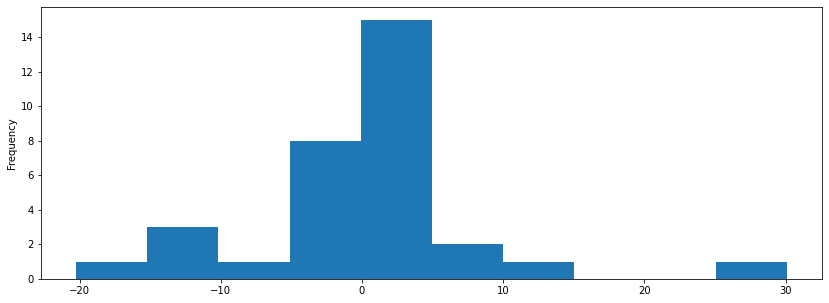

In [545]:
residuals.plot(kind="hist")

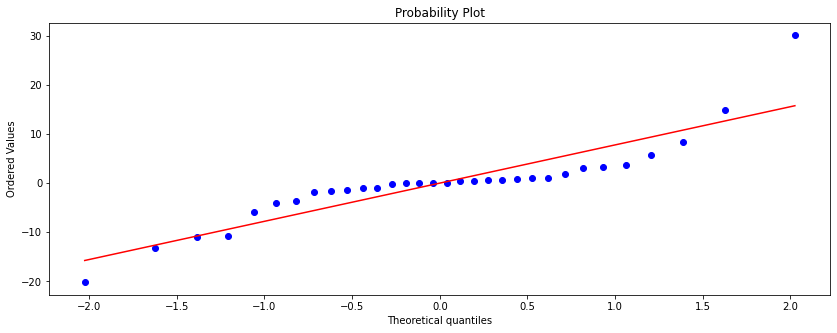

In [546]:
plt.figure()
stats.probplot(residuals, dist="norm", plot=plt)
plt.savefig(f"{figure_folder}/machine_learning_results/{mask_name}/qqplot_residuals.png", transparent=True, bbox_inches='tight', pad_inches=0.2)

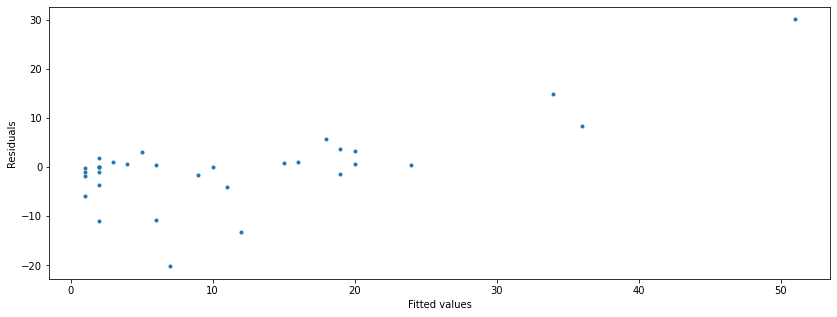

In [547]:
plt.figure()
plt.plot(y,residuals,'.')
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.savefig(f"{figure_folder}/machine_learning_results/{mask_name}/fitted_vs_predicted_residuals.png", transparent=True, bbox_inches='tight', pad_inches=0.2)

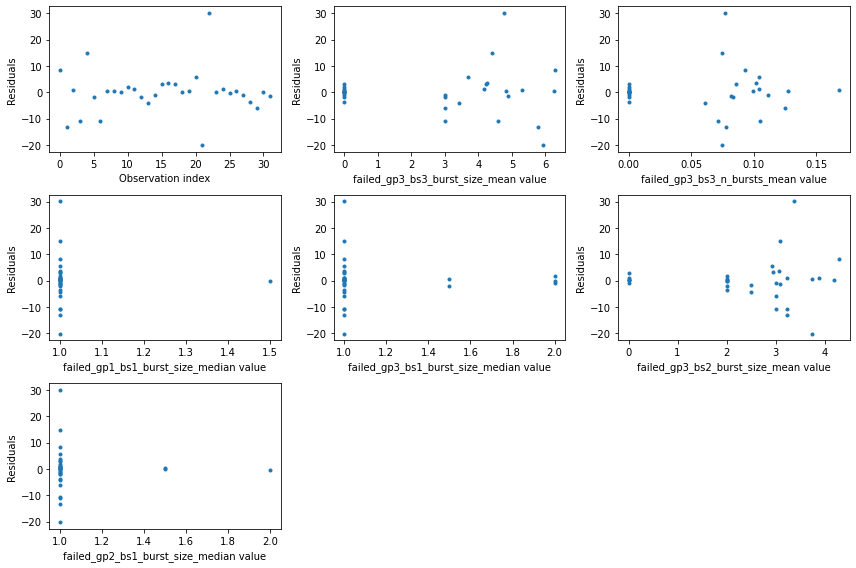

In [548]:
fig = plt.figure(figsize=(12,8))
i = 1
fig.add_subplot(3, 3, i)
plt.plot(residuals.values,'.')
#plt.title("Residuals against index")
plt.ylabel("Residuals")
plt.xlabel("Observation index")
plt.subplots_adjust(wspace=0.4)

for col in method_lin_regr_features[methods[0]]:
    fig.add_subplot(3, 3, i+1)
    i+=1
    plt.plot(x[col],residuals,'.')
    #plt.title("Residuals against " +str(col))
    plt.ylabel("Residuals")
    plt.xlabel(str(col)+" value")
    plt.subplots_adjust(wspace=0.4)
    plt.tight_layout()
plt.savefig(f"{figure_folder}/machine_learning_results/{mask_name}/indep_residuals.png", transparent=True, bbox_inches='tight', pad_inches=0.2)

In [549]:
model.intercept_

-1.3179682964979484

In [550]:
pd.Series(model.coef_, x.columns)

failed_gp3_bs3_burst_size_mean        4.511885
failed_gp3_bs3_n_bursts_mean       -112.395033
failed_gp1_bs1_burst_size_median      7.588970
failed_gp3_bs1_burst_size_median     -5.520215
failed_gp3_bs2_burst_size_mean        1.839370
failed_gp2_bs1_burst_size_median      1.183993
dtype: float64

[Text(1, 0, 'failed_gp3_bs3_burst_size_mean'),
 Text(2, 0, 'failed_gp3_bs3_n_bursts_mean'),
 Text(3, 0, 'failed_gp1_bs1_burst_size_median'),
 Text(4, 0, 'failed_gp3_bs1_burst_size_median'),
 Text(5, 0, 'failed_gp3_bs2_burst_size_mean'),
 Text(6, 0, 'failed_gp2_bs1_burst_size_median')]

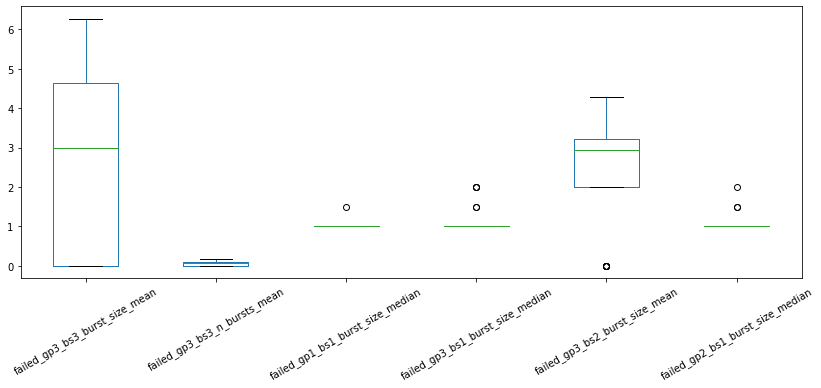

In [552]:
ax = x.plot(kind="box")
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)

### Quantiles

method_y_quantiles_train = {}
for method in methods:
    y_train = method_y_train[method]
    is_xsmall = y_train <= y_train.quantile(.16)
    is_small = (y_train > y_train.quantile(.16)) & (y_train <= y_train.quantile(.5))
    is_large = y_train >= y_train.quantile(.75)
    is_medium = ~(is_small | is_large | is_xsmall)

    y_quantiles = y_train.mask(is_xsmall, "xsmall").mask(is_small, 'small').mask(is_large, 'large').mask(is_medium, 'medium')
    print(y_quantiles.value_counts())
    method_y_quantiles_train[method] = y_quantiles

In [116]:
method_y_quantiles_train = {}
for method in methods:
    y_train = method_y_train[method]
    print("33", y_train.quantile(.33))
    print("66", y_train.quantile(.66))
    is_small = y_train <= y_train.quantile(.33)
    is_large = y_train >= y_train.quantile(.66)
    is_medium = ~(is_small | is_large)

    y_quantiles = y_train.mask(is_small, 0).mask(is_medium, 1).mask(is_large, 2)
    method_y_quantiles_train[method] = y_quantiles

33 2.2300000000000004
66 13.380000000000003
33 2.2300000000000004
66 13.380000000000003


In [117]:
method_y_quantiles_train[methods[0]].value_counts()

0.0    11
2.0    11
1.0    10
Name: post_release_bugs, dtype: int64

In [118]:
min_samples_leaf = [1,2,3,4]
max_depth = [4,8,16,None]
params_grid = {'min_samples_leaf': min_samples_leaf,
               "max_depth" : max_depth
              }

model = DecisionTreeClassifier()
method_dtclassifier_quantiles_f1 = {}
method_dtclassifier_quantiles_accuracy = {}
for method in methods:
    method_dtclassifier_quantiles_f1[method] = \
            two_layer_cross_validate(model, params_grid, method_x_train[method], method_y_quantiles_train[method], 5, 5, "f1_macro")
    method_dtclassifier_quantiles_accuracy[method] = \
            two_layer_cross_validate(model, params_grid, method_x_train[method], method_y_quantiles_train[method], 5, 5, "accuracy")

In [119]:
for method in methods:
    print(method, method_dtclassifier_quantiles_accuracy[method])
    print(method, method_dtclassifier_quantiles_f1[method])

dataset1 [0.66190476 0.52380952 0.51904762 0.66190476 0.26190476]
dataset1 [0.50888889 0.49640212 0.47555556 0.66444444 0.32      ]
dataset2 [0.5        0.47142857 0.5        0.44285714 0.31428571]
dataset2 [0.34349206 0.52111111 0.40666667 0.49809524 0.29925926]


In [120]:
method_knn_quantiles_features = {}
method_knn_quantiles_feature_performance = {}
for method in methods:
    features, score, feature_performance = forward_feature_selection(KNeighborsClassifier(), method_x_train[method],\
                                           method_y_quantiles_train[method], cv=cross_validation_strategy, scoring="f1_macro")
    print("-"*20)
    print(method, features, score)
    print("-"*20)
    method_knn_quantiles_features[method] = features
    method_knn_quantiles_feature_performance[method] = feature_performance

--------------------
dataset1 ['failed_gp1_bs1_n_bursts_max', 'max_errors_over_tests_total'] 0.5810185185185185
--------------------
--------------------
dataset2 ['mean_n_builds_per_pull_request', 'min_n_builds_per_pull_request', 'max_n_builds_per_pull_request'] 0.6166666666666667
--------------------


In [121]:
params_grid = {'n_neighbors': [int(x) for x in np.linspace(start = 1, stop = 10, num = 5)],
              'p': [1,2,3]}
model = KNeighborsClassifier()
method_knn_quantiles_f1 = {}
method_knn_quantiles_accuracy = {}
for method in methods:
    x = method_x_train[method][method_knn_quantiles_features[method]]
    method_knn_quantiles_f1[method] = \
            two_layer_cross_validate(model, params_grid, x, method_y_quantiles_train[method], 5, 5, "f1_macro")
    method_knn_quantiles_accuracy[method] = \
            two_layer_cross_validate(model, params_grid, method_x_train[method], method_y_quantiles_train[method], 5, 5, "accuracy")

In [122]:
for method in methods:
    print(method, method_knn_quantiles_f1[method])
    print(method, method_knn_quantiles_accuracy[method])

dataset1 [0.46238095 0.58619048 0.40936508 0.51746032 0.42333333]
dataset1 [0.4        0.3952381  0.31428571 0.38095238 0.26190476]
dataset2 [0.48666667 0.41148148 0.42825397 0.45190476 0.2437037 ]
dataset2 [0.23809524 0.42857143 0.33809524 0.38095238 0.31428571]


<Figure size 1008x360 with 0 Axes>

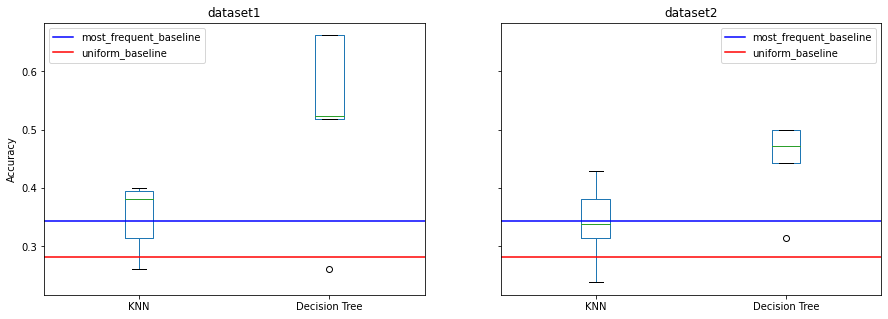

In [123]:
plt.figure()
fig, axes = plt.subplots(nrows=1, ncols=len(methods), sharey=True, figsize=(15.0, 5.0))
scores = {"KNN": method_knn_quantiles_accuracy, 
          "Decision Tree": method_dtclassifier_quantiles_accuracy}
for i, method in enumerate(methods):
    data = {}
    y_quantiles = method_y_quantiles_train[method]
    for model, score in scores.items():
        data[model] = score[method]
    ax = pd.DataFrame(data).plot(kind="box", ax=axes[i])
    x = method_x_train[method]
    ax.axhline(y=accuracy_score(DummyClassifier(strategy="most_frequent").fit(x, y_quantiles).predict(y_quantiles), y_quantiles), color="b", label="most_frequent_baseline")
    ax.axhline(y=accuracy_score(DummyClassifier(strategy="uniform", random_state=4).fit(x, y_quantiles).predict(y_quantiles), y_quantiles), color="r", label="uniform_baseline")
    ax.legend()
    ax.set_title(method)
    if i == 0:
        ax.set(ylabel="Accuracy")
plt.savefig(f"{figure_folder}/machine_learning_results/{mask_name}/quantile_accuracy.png", transparent=True, bbox_inches='tight', pad_inches=0.2)

<Figure size 1008x360 with 0 Axes>

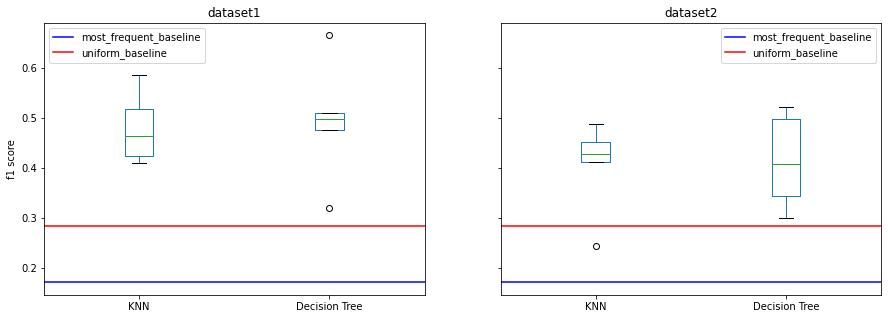

In [124]:
plt.figure()
fig, axes = plt.subplots(nrows=1, ncols=len(methods), sharey=True, figsize=(15.0, 5.0))
scores = {"KNN": method_knn_quantiles_f1, 
          "Decision Tree": method_dtclassifier_quantiles_f1}
for i, method in enumerate(methods):
    data = {}
    y_quantiles = method_y_quantiles_train[method]
    for model, score in scores.items():
        data[model] = score[method]
    ax = pd.DataFrame(data).plot(kind="box", ax=axes[i])
    x = method_x_train[method]
    ax.axhline(y=f1_score(DummyClassifier(strategy="most_frequent").fit(x, y_quantiles).predict(y_quantiles), y_quantiles, average="macro"), color="b", label="most_frequent_baseline")
    ax.axhline(y=f1_score(DummyClassifier(strategy="uniform", random_state=4).fit(x, y_quantiles).predict(y_quantiles), y_quantiles, average="macro"), color="r", label="uniform_baseline")
    ax.legend()
    ax.set_title(method)
    if i == 0:
        ax.set(ylabel="f1 score")
plt.savefig(f"{figure_folder}/machine_learning_results/{mask_name}/quantile_f1.png", transparent=True, bbox_inches='tight', pad_inches=0.2)

**Interpreting DT for method0**

<Figure size 1008x360 with 0 Axes>

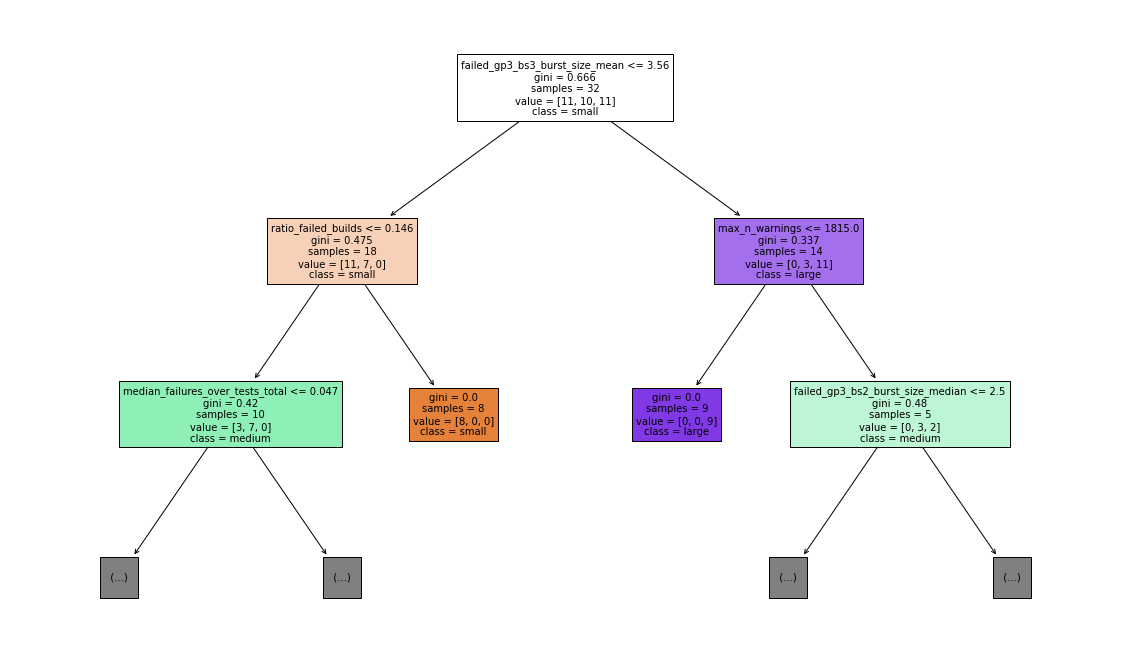

In [125]:
plt.figure()
from sklearn.tree import plot_tree
dt = DecisionTreeClassifier()
dt.fit(methods_indep_var[methods[0]], method_y_quantiles_train[methods[0]])
fig, ax = plt.subplots(figsize=(20, 12))
plot_tree(dt, feature_names=method_x_train[methods[0]].columns, max_depth=2, filled=True, class_names=["small", "medium", "large"], fontsize=10)
plt.savefig(f"{figure_folder}/machine_learning_results/{mask_name}/dt_method0.png", transparent=True, bbox_inches='tight', pad_inches=0.2)

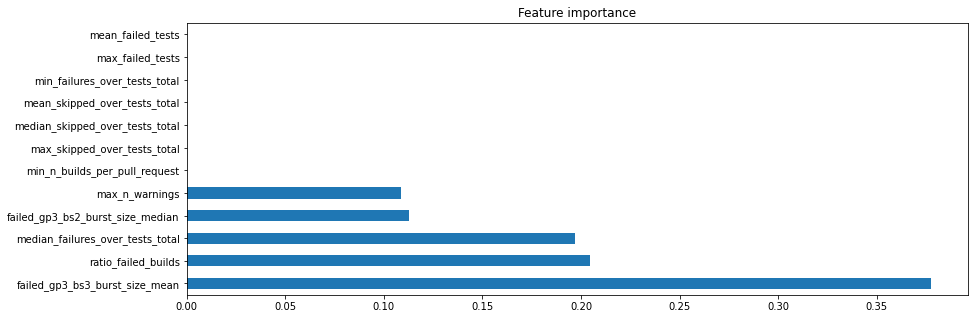

In [126]:
plt.figure()
ax = pd.Series(dt.feature_importances_, method_x_train[methods[0]].columns).sort_values(ascending=False).head(12).plot(kind="barh")
ax.set_title("Feature importance")
plt.savefig(f"{figure_folder}/machine_learning_results/{mask_name}/dt_f_impo_method0.png", transparent=True, bbox_inches='tight', pad_inches=0.2)

**Interpreting KNN for method1**

<ipython-input-127-ee34f9726604>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["classes"] = method_y_quantiles_train[m].map({0:"small", 1:"medium", 2:"large"})
/Users/alexincerti/Library/Python/3.8/lib/python/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


<Figure size 1008x360 with 0 Axes>

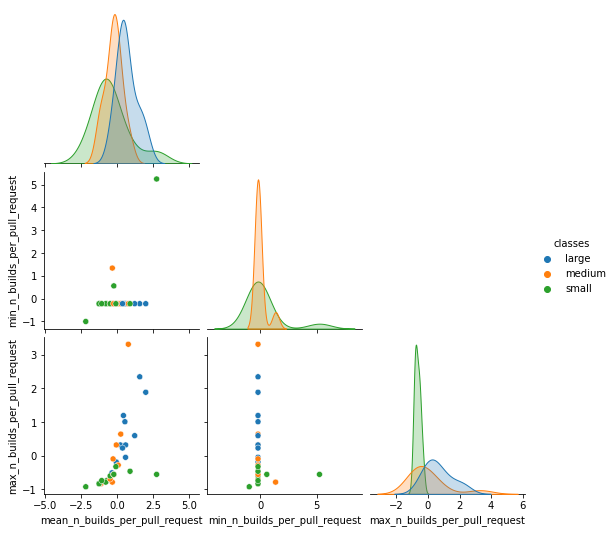

In [127]:
plt.figure()
m = methods[1]
df = method_x_train[m][method_knn_quantiles_features[m]]
df["classes"] = method_y_quantiles_train[m].map({0:"small", 1:"medium", 2:"large"})
"""sns.scatterplot(data=df, x="max_failed_build_duration", y="failed_gp3_bs3_burst_size_mean", marker="o",\
                hue="quantiles", palette="deep")"""
sns.pairplot(df, hue="classes",corner=True)
plt.savefig(f"{figure_folder}/machine_learning_results/{mask_name}/knn_method1_plot.png", transparent=True, bbox_inches='tight', pad_inches=0.2)

### Binary

for method in methods:
    method_x_train[method] = method_x_train[method].drop(columns=["max_n_builds_per_pull_request"])

In [664]:
method_y_bin_train = {}
for method in methods:
    method_y_bin_train[method] = method_y_train[method] > method_y_train[method].median()

In [665]:
method_y_train[method].median()

6.5

In [666]:
min_samples_leaf = [1,2,3,4]
max_depth = [4,8,16,None]
params_grid = {'min_samples_leaf': min_samples_leaf,
               "max_depth" : max_depth
              }

model = DecisionTreeClassifier()
method_randomclassifier_binary_f1 = {}
method_dtclassifier_binary_accuracy = {}
method_dtclassifier_binary_auc = {}
for method in methods:
    method_randomclassifier_binary_f1[method] = \
            two_layer_cross_validate(model, params_grid, method_x_train[method], method_y_bin_train[method], 5, 4, "f1")
    method_dtclassifier_binary_accuracy[method] = \
            two_layer_cross_validate(model, params_grid, method_x_train[method], method_y_bin_train[method], 5, 4, "accuracy")
    method_dtclassifier_binary_auc[method] = \
            two_layer_cross_validate(model, params_grid, method_x_train[method], method_y_bin_train[method], 5, 4, "roc_auc")

In [667]:
for method in methods:
    print(method, "F1", method_dtclassifier_binary_accuracy[method], method_dtclassifier_binary_accuracy[method].mean())
    print(method, "Accuracy", method_randomclassifier_binary_f1[method], method_randomclassifier_binary_f1[method].mean())
    print(method, method_dtclassifier_binary_auc[method])

dataset1 F1 [0.375 0.875 0.375 0.875] 0.625
dataset1 Accuracy [0.28571429 0.88888889 0.44444444 0.66666667] 0.5714285714285714
dataset1 [0.36666667 0.9        0.46666667 1.        ]
dataset2 F1 [0.75  0.875 1.    0.875] 0.875
dataset2 Accuracy [0.66666667 0.88888889 1.         0.8       ] 0.8388888888888888
dataset2 [0.36666667 0.86666667 1.         0.8       ]


In [668]:
method_knn_bin_features = {}
method_knn_bin_feature_performance = {}
for method in methods:
    features, score, feature_performance = forward_feature_selection(KNeighborsClassifier(), method_x_train[method],\
                                           method_y_bin_train[method], cv=cross_validation_strategy, scoring="f1")
    print("-"*20)
    print(method, features, score)
    print("-"*20)
    method_knn_bin_features[method] = features
    method_knn_bin_feature_performance[method] = feature_performance

--------------------
dataset1 ['failed_gp1_bs2_burst_size_mean'] 0.886904761904762
--------------------
--------------------
dataset2 ['max_failed_tests', 'max_n_builds_per_pull_request'] 0.8865079365079365
--------------------


In [669]:
params_grid = {'n_neighbors': [int(x) for x in np.linspace(start = 1, stop = 10, num = 5)],
              'p': [1,2,3]}
model = KNeighborsClassifier()
method_knn_f1 = {}
method_knn_accuracy = {}
method_knn_auc = {}
for method in methods:
    x = method_x_train[method][method_knn_bin_features[method]]
    method_knn_f1[method] = \
            two_layer_cross_validate(model, params_grid, x, method_y_bin_train[method], 5, 4, "f1")
    method_knn_accuracy[method] = \
            two_layer_cross_validate(model, params_grid, x, method_y_bin_train[method], 5, 4, "accuracy")
    method_knn_auc[method] = \
            two_layer_cross_validate(model, params_grid, x, method_y_bin_train[method], 5, 4, "roc_auc")


In [670]:
for method in methods:
    print(method, "F1", method_knn_f1[method], method_knn_f1[method].mean())
    print(method, "Accuracy", method_knn_accuracy[method], method_knn_accuracy[method].mean())
    print(method, method_knn_auc[method])

dataset1 F1 [0.85714286 1.         0.72727273 0.85714286] 0.8603896103896104
dataset1 Accuracy [0.875 1.    0.625 0.875] 0.84375
dataset1 [0.83333333 1.         0.56666667 0.93333333]
dataset2 F1 [0.85714286 0.88888889 1.         0.8       ] 0.8865079365079365
dataset2 Accuracy [0.875 0.875 1.    0.875] 0.90625
dataset2 [0.86666667 0.83333333 1.         0.83333333]


<Figure size 1008x360 with 0 Axes>

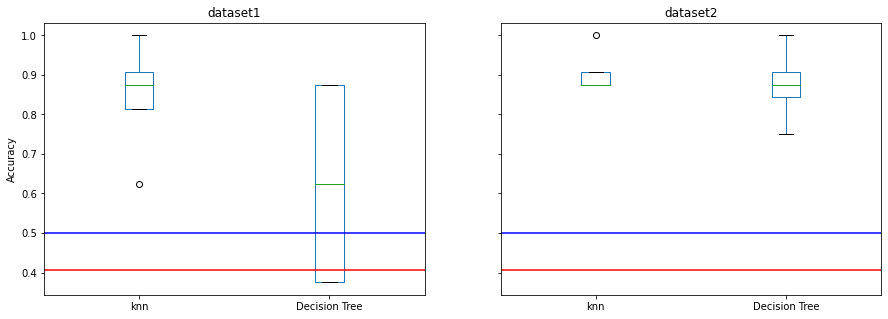

In [671]:
plt.figure()
fig, axes = plt.subplots(nrows=1, ncols=len(methods), sharey=True, figsize=(15.0, 5.0))
scores = {"knn": method_knn_accuracy, 
          "Decision Tree": method_dtclassifier_binary_accuracy}
for i, method in enumerate(methods):
    data = {}
    y_bin = method_y_bin_train[method]
    for model, score in scores.items():
        data[model] = score[method]
    ax = pd.DataFrame(data).plot(kind="box", ax=axes[i])
    x = method_x_train[method]
    ax.axhline(y=accuracy_score(DummyClassifier(strategy="most_frequent").fit(x, y_bin).predict(y_bin), y_bin), color="b", label="most_frequent_baseline")
    ax.axhline(y=accuracy_score(DummyClassifier(strategy="uniform", random_state=4).fit(x, y_bin).predict(y_bin), y_bin), color="r", label="uniform_baseline")
    #ax.legend()
    ax.set_title(method)
    if i == 0:
        ax.set(ylabel="Accuracy")
plt.savefig(f"{figure_folder}/machine_learning_results/{mask_name}/binary_accuracy.png", transparent=True, bbox_inches='tight', pad_inches=0.2)

<Figure size 1008x360 with 0 Axes>

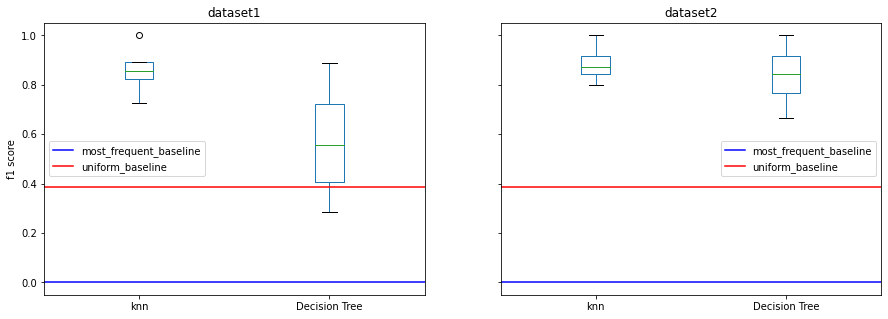

In [672]:
plt.figure()
fig, axes = plt.subplots(nrows=1, ncols=len(methods), sharey=True, figsize=(15.0, 5.0))
scores = {"knn": method_knn_f1, 
          "Decision Tree": method_randomclassifier_binary_f1}
for i, method in enumerate(methods):
    data = {}
    y_bin = method_y_bin_train[method]
    for model, score in scores.items():
        data[model] = score[method]
    ax = pd.DataFrame(data).plot(kind="box", ax=axes[i])
    x = method_x_train[method]
    ax.axhline(y=f1_score(DummyClassifier(strategy="most_frequent").fit(x, y_bin).predict(y_bin), y_bin), color="b", label="most_frequent_baseline")
    ax.axhline(y=f1_score(DummyClassifier(strategy="uniform", random_state=4).fit(x, y_bin).predict(y_bin), y_bin), color="r", label="uniform_baseline")
    ax.legend()
    ax.set_title(method)
    if i == 0:
        ax.set(ylabel="f1 score")
plt.savefig(f"{figure_folder}/machine_learning_results/{mask_name}/binary_f1.png", transparent=True, bbox_inches='tight', pad_inches=0.2)

<Figure size 1008x360 with 0 Axes>

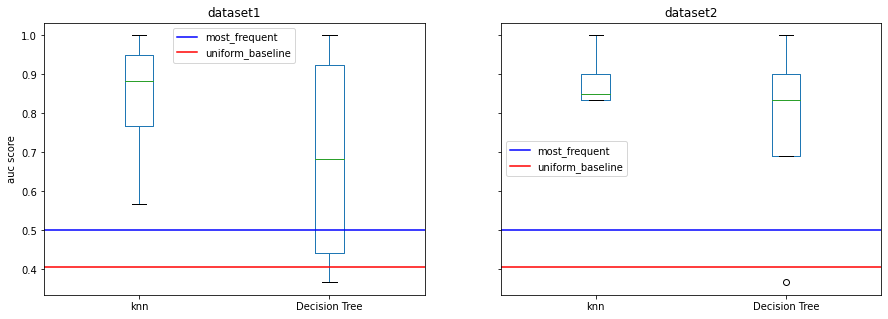

In [673]:
plt.figure()
fig, axes = plt.subplots(nrows=1, ncols=len(methods), sharey=True, figsize=(15.0, 5.0))
scores = {"knn": method_knn_auc, 
          "Decision Tree": method_dtclassifier_binary_auc}
for i, method in enumerate(methods):
    data = {}
    y_bin = method_y_bin_train[method]
    for model, score in scores.items():
        data[model] = score[method]
    ax = pd.DataFrame(data).plot(kind="box", ax=axes[i])
    x = method_x_train[method]
    ax.axhline(y=0.5, color="b", label="most_frequent")
    ax.axhline(y=roc_auc_score(DummyClassifier(strategy="uniform", random_state=4).fit(x, y_bin).predict(y_bin), y_bin), color="r", label="uniform_baseline")
    ax.legend()
    ax.set_title(method)
    if i == 0:
        ax.set(ylabel="auc score")
plt.savefig(f"{figure_folder}/machine_learning_results/{mask_name}/binary_auc.png", transparent=True, bbox_inches='tight', pad_inches=0.2)

<ipython-input-688-fdcc1bc9d558>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["classes"] = method_y_bin_train[method].map({True:"large", False:"small"})


<Figure size 1008x360 with 0 Axes>

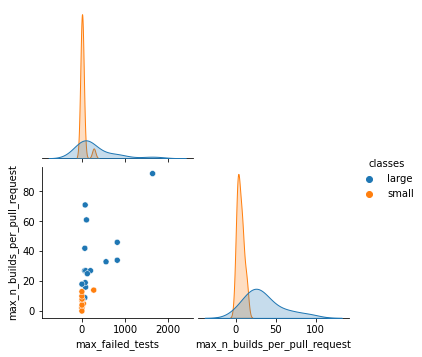

In [688]:
for i, method in enumerate([methods[1]]):
    plt.figure()
    df = methods_indep_var[method][method_knn_bin_features[method]]
    #if i == 0:
    #df = df[(df.max_n_builds_per_pull_request < 40)]
    #if i == 1:
        #df = df[(df.mean_failed_tests < 0.05) & (df.max_n_builds_per_pull_request < 1)]
    df["classes"] = method_y_bin_train[method].map({True:"large", False:"small"})
    """sns.scatterplot(data=df, x="max_failed_build_duration", y="failed_gp3_bs3_burst_size_mean", marker="o",\
                    hue="quantiles", palette="deep")"""
    sns.pairplot(df, hue="classes",corner=True)
    plt.savefig(f"{figure_folder}/machine_learning_results/{mask_name}/knn_{method}_bin_plot.png", transparent=True, bbox_inches='tight', pad_inches=0.2)

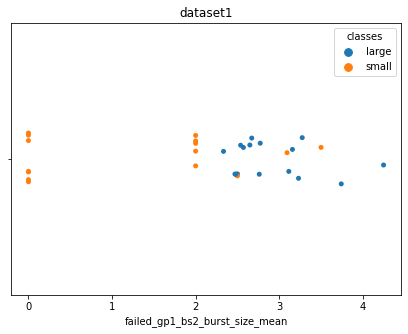

In [702]:
fig, ax = plt.subplots(figsize=(7, 5))
method = methods[0]
df = methods_indep_var[method][method_knn_bin_features[method]]
y = methods_dep_var[method].post_release_bugs
df = df[df.failed_gp1_bs2_burst_size_mean < 4.5]
df["classes"] = method_y_bin_train[m].map({False:"small", True:"large"})
df[""] = ""
ax = sns.stripplot(x="failed_gp1_bs2_burst_size_mean",\
                     y="",hue="classes", data=df, ax=ax)
ax.set_title("dataset1")
plt.savefig(f"{figure_folder}/machine_learning_results/{mask_name}/knn_{method}_bin_plot.png", transparent=True, bbox_inches='tight', pad_inches=0.2)

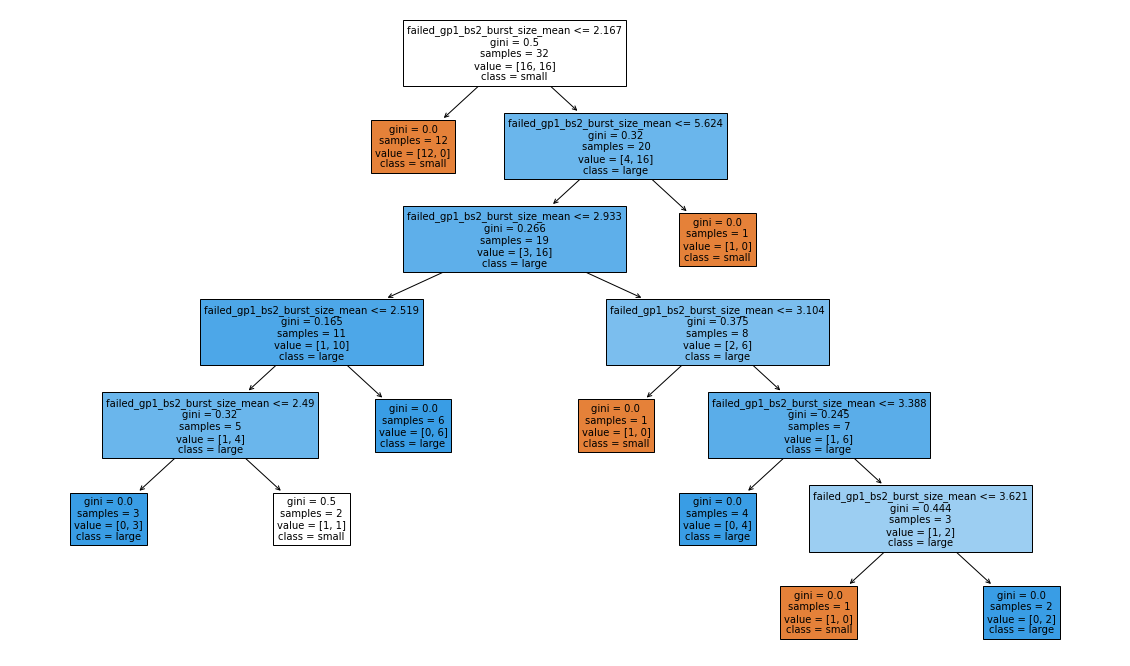

In [697]:
from sklearn.tree import plot_tree
dt = DecisionTreeClassifier()
dt.fit(methods_indep_var[methods[0]][["failed_gp1_bs2_burst_size_mean"]], method_y_bin_train[methods[0]])
fig, ax = plt.subplots(figsize=(20, 12))
plot_tree(dt, feature_names=method_x_train[methods[0]][["failed_gp1_bs2_burst_size_mean"]].columns, filled=True, class_names=["small", "large"], fontsize=10)
plt.show()

**----------------------------------------**

### PCA

In [382]:
from sklearn.decomposition import PCA
pca = PCA(n_components=20)
X = methods_indep_var[methods[1]][mask]
X = StandardScaler().fit_transform(X)
y = methods_dep_var[methods[1]][mask].java_build_tool.reset_index(drop=True)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents)

In [383]:
finalDf = pd.concat([principalDf, y], axis = 1)

In [392]:
pca.explained_variance_ratio_[:1].sum()

0.23559056005146486

<AxesSubplot:>

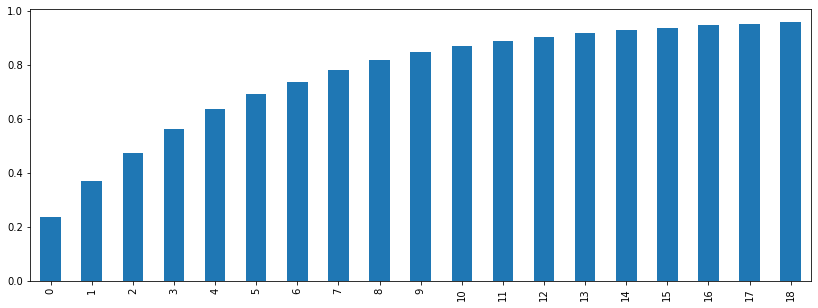

In [402]:
data = []
for i in range(1, len(pca.explained_variance_ratio_)):
    data.append((i, pca.explained_variance_ratio_[:i].sum()))
pd.DataFrame(data)[1].plot(kind="bar")

In [346]:
X_pca = pca.transform(X)

In [404]:
y_bugs = methods_dep_var[methods[1]].post_release_bugs

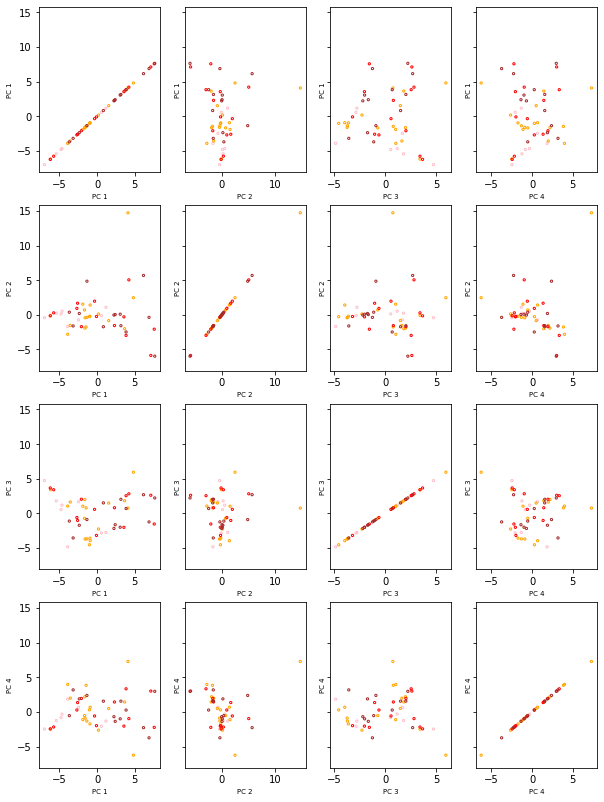

In [409]:
#plt.scatter(X_pca, y)
n_components = 4
fig, axes = plt.subplots(nrows=n_components, ncols=n_components, sharey=True, figsize=(10.0, 14.0))
for i in range(0,n_components):
    for j in range(0,n_components):
        ax = axes[i][j]
        ax.set_xlabel(f"PC {j+1}", fontsize = 7)
        ax.set_ylabel(f"PC {i+1}", fontsize = 7)
        colors = ["pink",'orange','red','brown','black']
        ranges = [(0,y_bugs.quantile(0.25)),(y_bugs.quantile(0.25),y_bugs.quantile(0.5))\
                  ,(y_bugs.quantile(0.5),y_bugs.quantile(0.75)), (y_bugs.quantile(0.75),y_bugs.quantile(1))]
        for rang, color in zip(ranges, colors):
            indicesToKeep = (y_bugs>=rang[0]) & (y_bugs<rang[1])
            ax.scatter(finalDf.loc[indicesToKeep, j],
                       finalDf.loc[indicesToKeep, i],
                       s = 5,
                       facecolors='none',
                       edgecolors=color)

In [421]:
df = pd.DataFrame(X)
df.columns = df.columns.astype(str)

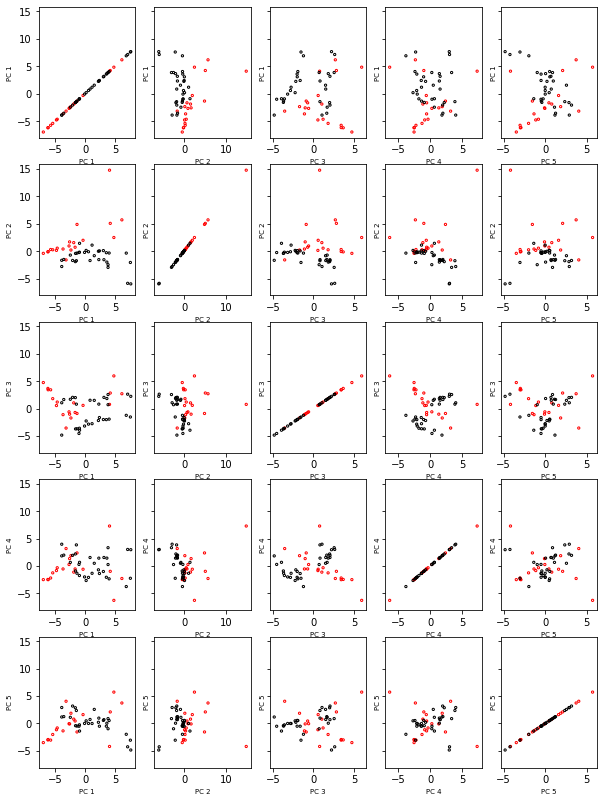

In [381]:
#plt.scatter(X_pca, y)
fig, axes = plt.subplots(nrows=5, ncols=5, sharey=True, figsize=(10.0, 14.0))
for i in range(0,5):
    for j in range(0,5):
        ax = axes[i][j]
        ax.set_xlabel(f"PC {j+1}", fontsize = 7)
        ax.set_ylabel(f"PC {i+1}", fontsize = 7)
        colors = ['r','black']
        ranges = ["gradle", "maven"]
        for rang, color in zip(ranges, colors):
            indicesToKeep = (y==rang)
            ax.scatter(finalDf.loc[indicesToKeep, j],
                       finalDf.loc[indicesToKeep, i],
                       s = 5,
                       facecolors='none',
                       edgecolors=color)